In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from numpy import genfromtxt
import matplotlib.pyplot as plt
import time
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import array
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.cluster import AffinityPropagation

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Num GPUs Available:  4


## Agumentation

In [3]:
def gene_filtering(genepath):    

    # Ensembl ID
    gnames = np.array(pd.read_csv(genepath))[:,0]
    
    # Gene symbol : gene name
    glists = np.array(pd.read_csv(genepath))[:,1]

    return gnames, glists

In [4]:
def extract_filtered_gene(datapath, gnames):
    
    #Load dataset
    rld = np.genfromtxt(datapath, delimiter = ',', dtype = 'str')
    label, gene, value = rld[0][1:], rld[1:,0], rld[1:,1:].T
    label = np.array([x.replace('"', '') for x in label])
    gene = np.array([x.replace('"', '') for x in gene])
    value = value.astype(np.float32)

    #Extract filtered genes
    eidx = []
    for g in range(len(gnames)):
        idx = np.where(gnames[g] == gene)[0][0]
        eidx.append(idx)

    evalue, egene = value[:, eidx], gnames
    return evalue, egene, label

In [5]:
def data_augmentation(evalue, egene, elabel, save=True, file_name='test'):

    aug_values = []
    aug_labels = []
    
    sp_size = 6
    
    n_time = 2
    n_treatment = 3
        
    for ti in range(n_time): #time
        #
        for tr in range(n_treatment): #treatment
            #
            for s in range(sp_size): #samples
                s1 = ti*18+tr*6+s
                for s_ in range(s, sp_size):
                    s2 = ti*18+tr*6+s_
                    tmp1, tmp2 = evalue[s1], evalue[s2]
                    if(s==s_): #rawdata
                        aug_values.append(tmp1)
                        aug_labels.append(elabel[s1])
                    else: #augmentation
                        for r in range(19):
                            augx = tmp1*(r+1)*0.05+tmp2*(19-r)*0.05
                            aug_values.append(augx)
                            aug_labels.append(elabel[s1]+'+'+elabel[s2]+'+'+str(r+1))
                            
    aug_values, aug_labels = np.array(aug_values), np.array(aug_labels),

    print ('augmented_data.shape :', aug_values.shape)
    
    
    if save==True:
        np.savez('augmented_2254G_twice.npz', genelist=egene, values=aug_values,labels=aug_labels)
        
    print ('Augmented input is saved!')
    
    return [egene, aug_values, aug_labels]

## 1. Preprocess dataset

In [6]:
##Gene filtering and augmentation

input_ = 'augmented_2254G_twice.npz'

res_path = 'Res_HBMVEC_Union_C1_to_C6_NovelRemoved_2254genes.csv'
rld_path = 'Rld_HBMVEC_Union_C1_to_C6_NovelRemoved_2254genes.csv'
ex_gnames, ex_glists = gene_filtering(res_path)
ex_value, ex_gene, ex_label = extract_filtered_gene(rld_path, ex_gnames)

augmented_data = data_augmentation(ex_value, ex_glists, ex_label, True, input_)


dat = np.load(input_,allow_pickle=True)
rlds, genelist, augsample = dat['values'], dat['genelist'], dat['labels']

realidx = [0, 291, 582, 873, 1164, 1455]

augmented_data.shape : (1746, 2254)
Augmented input is saved!


In [7]:
# Label Indexing
Agg24 = np.array([0,96,173,231,270,290])
Agg72 = np.add(Agg24, 291)
Cont24, Cont72 = np.add(Agg24,2*291), np.add(Agg24,3*291)
Mono24, Mono72 = np.add(Agg24,4*291), np.add(Agg24,5*291)
Aug_Agg24 = np.arange(291)
Aug_Agg72 = np.add(Aug_Agg24,291)
Aug_Cont24, Aug_Cont72 = np.add(Aug_Agg24,2*291), np.add(Aug_Agg24,3*291)
Aug_Mono24, Aug_Mono72 = np.add(Aug_Agg24,4*291), np.add(Aug_Agg24,5*291)

## 2. Rescaling(normalization)

In [8]:
# Rescaling

cond_list = [Aug_Agg24,Aug_Agg72,Aug_Cont24,Aug_Cont72,Aug_Mono24,Aug_Mono72]
rld_mean = np.average(rlds, axis=0)

rld_std = np.zeros((len(cond_list),rlds.shape[1]))

for c in range(len(cond_list)):
    rld_std[c] = np.std(rlds[cond_list[c]], axis=0)
    
max_rld_std = np.max(rld_std, axis=0)
avg_rld_std = np.average(rld_std, axis=0)
all_rld_std = np.std(rlds,axis=0)

In [9]:
##IQR filter 

num_25 = 25 
all_q1=stats.scoreatpercentile(all_rld_std, num_25)
max_q1=stats.scoreatpercentile(max_rld_std, num_25)
num_75 = 75
all_q3=stats.scoreatpercentile(all_rld_std, num_75)
max_q3=stats.scoreatpercentile(max_rld_std, num_75)

all_rld_std_filter=np.where(all_rld_std<all_q1,all_q1,all_rld_std)
all_rld_std_filter_f=np.where(all_rld_std>all_q3,all_q3,all_rld_std_filter)
max_rld_std_filter=np.where(max_rld_std<max_q1,max_q1,max_rld_std) 
max_rld_std_filter_f=np.where(max_rld_std>max_q3,max_q3,max_rld_std_filter) 
two_rld_std_f = []
two_rld_std_f.append(all_rld_std_filter_f)
two_rld_std_f.append(max_rld_std_filter_f)
two_rld_std_f = np.array(two_rld_std_f)
gmean_rld_std_f = stats.gmean(two_rld_std_f,axis=0)

re_rld_f = (rlds-rld_mean)/gmean_rld_std_f
std_re_rld_f = np.std(re_rld_f.flatten())

### Within 95% 
re_rld_norm_f = re_rld_f/(2*1.959*std_re_rld_f)+0.5
rld=re_rld_norm_f

In [10]:
nrld = rld.flatten()
te_ratio = 0.1

#split training and test dataset
x_idx = np.arange(len(rld))
te_idx = np.random.choice(len(rld), int(len(rld)*te_ratio), False)
tr_idx = np.setdiff1d(x_idx, te_idx)
xtr, xte = rld[tr_idx], rld[te_idx]
tr_max = np.max(xtr)
n_tr, n_te = len(xtr), len(xte)

print ('xtr:', xtr.shape, ', xte:', xte.shape)
n, p = xtr.shape
print(n ,p)

xtr: (1572, 2254) , xte: (174, 2254)
1572 2254


In [11]:
# Hyperparameter setting
lr = 1e-6
EPOCHS = 200000   # Epochs to train
critic = 5     # Critic updates per generator update 
gradient_penalty_weight = 10.0 #lambda setting
BUFFER_SIZE = 20
BATCH_SIZE = 64

gen_size, disc_size = 400, 240

In [12]:
rld = rld.astype('float32')
rld_max = np.max(rld)
print(rld_max)

train_dataset = tf.data.Dataset.from_tensor_slices(rld).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset)

2.7208507
<BatchDataset shapes: (None, 2254), types: tf.float32>


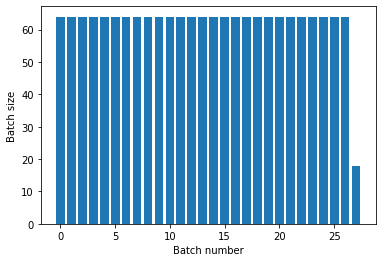

In [13]:
def plot_batch_sizes(ds):
    batch_sizes = [batch.shape[0] for batch in ds]
    plt.bar(range(len(batch_sizes)), batch_sizes)
    plt.xlabel('Batch number')
    plt.ylabel('Batch size')
    
plot_batch_sizes (train_dataset)

In [14]:
# optimizer

#Logic to avoid gradient exploding
lr_schedule = tf.keras.experimental.CosineDecayRestarts(
    initial_learning_rate=1e-5, 
    first_decay_steps=5000000, 
    t_mul=10.0, 
    m_mul=0.8)
generator_optimizer = tf.keras.optimizers.Adam(lr_schedule)
discriminator_optimizer = tf.keras.optimizers.Adam(lr_schedule)

In [15]:
#Setting training data save folder
log_dir="learning_logs//"
sub_path = log_dir + "G400D240"

summary_writer = tf.summary.create_file_writer(sub_path)

In [16]:
noise_dim = 100
nrld = rld.flatten()

def get_noise(batch_size):
    #seed = tf.random.normal([num_examples_to_generate, noise_dim])

    seed = nrld[np.random.randint(0,len(nrld),size=(batch_size, noise_dim))]
    #print(seed)
    seed = tf.convert_to_tensor(seed)
    #print(seed)
    return seed

In [17]:
idx_ = np.random.choice(n_tr, BATCH_SIZE, replace=False)
print(idx_)
print(xtr[idx_])

[ 212 1228  131  226  657 1232  385  341 1097 1046 1512 1469    4 1555
 1252  763 1484  606  958 1328  755  506 1569 1493  852 1420  621  920
 1317 1447  122  922 1266  146  953   19  315  479  572  395 1079 1295
  156  669  368  969  957 1451   58 1261   98 1236 1307  106  886 1497
  136 1308   81  436  113  830  651 1115]
[[0.56745701 0.51912939 0.21446084 ... 0.49838146 0.71879068 0.79636977]
 [0.5050918  0.81611041 0.51589399 ... 0.42168678 0.97503514 0.94782994]
 [0.43168505 0.47239728 0.33301854 ... 0.50031255 0.69574051 0.80722012]
 ...
 [0.57184852 0.21869091 0.66921143 ... 0.43066631 0.11669083 0.08545398]
 [0.51371565 0.88509925 0.62628281 ... 0.37928354 1.13734377 1.1317643 ]
 [0.47937334 0.71677864 0.57449794 ... 0.2869916  1.015604   0.96419465]]


In [18]:
gen_init=0.3
def make_generator_model():
    model = keras.Sequential([
        layers.Dense(gen_size, input_shape=(noise_dim, ), kernel_initializer=tf.random_uniform_initializer(-gen_init,gen_init)),
        layers.LeakyReLU(),
        layers.Dense(gen_size, kernel_initializer=tf.random_uniform_initializer(-gen_init,gen_init)),
        layers.LeakyReLU(),
        layers.Dense(p, kernel_initializer=tf.random_uniform_initializer(-gen_init,gen_init))
    ])
    return model

generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 450)               45450     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 450)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 450)               202950    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 450)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2254)              1016554   
Total params: 1,264,954
Trainable params: 1,264,954
Non-trainable params: 0
_________________________________________________________________


In [19]:
noise = get_noise(1)
generated_rlds = generator(noise, training=False)

print(generated_rlds)

tf.Tensor([[ 1.5893984  7.311874  -1.7328029 ...  6.9961677 -4.5896006  2.1047447]], shape=(1, 2254), dtype=float32)


In [20]:
def make_discriminator_model():
    model = keras.Sequential([
        layers.Dense(disc_size, input_shape=(p, )),
        layers.LeakyReLU(),
        layers.Dense(disc_size),
        layers.LeakyReLU(),
        layers.Dense(1)
    ])   
    return model

discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 270)               608850    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 270)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 270)               73170     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 270)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 271       
Total params: 682,291
Trainable params: 682,291
Non-trainable params: 0
_________________________________________________________________


In [21]:
decision = discriminator(generated_rlds)
print (decision)

tf.Tensor([[-0.06615274]], shape=(1, 1), dtype=float32)


In [22]:
checkpoint_dir = sub_path + "/training_checkpoints"
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

print(checkpoint_dir)

learning_logs/test/G450D270/training_checkpoints


In [23]:
@tf.function
def train_gen(rlds, noise):
    #batch_size = rlds.get_shape().as_list()[0]
    
    with tf.GradientTape() as t:
        #noise = get_noise(batch_size)
        generated_rlds = generator(noise, training=True)
        fake_output = discriminator(generated_rlds, training=True)
        
        loss = generator_loss(fake_output)
    gradients = t.gradient(loss, generator.trainable_variables)
    
    #theta_G = [var for var in generator.trainable_variables]
    #generator_optimizer.minimize(loss, theta_G)
    
    generator_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))
    return loss

In [24]:
@tf.function
def train_disc(rlds, noise):
    #batch_size = rlds.get_shape().as_list()[0]
    
        
    with tf.GradientTape() as t:
        #noise = get_noise(batch_size)
        generated_rlds = generator(noise, training=True)
        fake_output = discriminator(generated_rlds, training=True)
        real_output = discriminator(rlds, training=True)
        
        gp = gradient_penalty(rlds, generated_rlds)
        loss = discriminator_loss(fake_output, real_output) + gp
        #loss = discriminator_loss(fake_output, real_output)
        gradients = t.gradient(loss, discriminator.trainable_variables)
    
    #theta_D = [var for var in discriminator.trainable_variables]
    #discriminator_optimizer.minimize(-loss, theta_D)
        
    discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))
    return loss 

In [25]:
def generator_loss(fake_output):
    fake_loss = -tf.reduce_mean(fake_output)
    return fake_loss

def discriminator_loss(fake_output, real_output):
    fake_loss = tf.reduce_mean(fake_output)
    real_loss = tf.reduce_mean(real_output)
    return fake_loss - real_loss

In [26]:
# gradient penalty 
def gradient_penalty(rlds, generated_rlds):
    batch_size = rlds.get_shape().as_list()[0]
    epsilon = tf.random.uniform (shape=[batch_size, 1], minval=0., maxval=rld_max)
    x_hat = (epsilon * rlds) + ((1 - epsilon) * generated_rlds)
    #x_hat = (epsilon * generated_rlds) + ((1 - epsilon) * rlds)
    with tf.GradientTape() as gp:
        gp.watch(x_hat)
        d_hat = discriminator(x_hat, training=True)
    gradients = gp.gradient(d_hat, [x_hat])[0]
    d_gradient = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=1))
    d_regularizer = gradient_penalty_weight * tf.reduce_mean(tf.square(d_gradient-1.))
    return d_regularizer 

In [27]:
gen_loss_results = []
disc_loss_results = []
gen_rlds = []

start = time.time()
num_to_generate = 84

for epoch in range(EPOCHS):
    epoch_gen_loss_avg = tf.keras.metrics.Mean()
    epoch_disc_loss_avg = tf.keras.metrics.Mean()
    
    for batch in train_dataset:
        noise = get_noise(batch.shape[0])
        for _ in range (critic):
            #train_disc(batch)
            d_loss = train_disc(batch, noise)           
            epoch_disc_loss_avg(d_loss)
        g_loss = train_gen(batch, noise)
        epoch_gen_loss_avg(g_loss)
        #train_gen(batch)
        
    gen_loss_results.append(epoch_gen_loss_avg.result())
    disc_loss_results.append(epoch_disc_loss_avg.result())
    
    if (epoch + 1) % 500 == 0:
        checkpoint_prefix = checkpoint_dir + "/cp-" + str(epoch+1) + '.ckpt'
        checkpoint.save(file_prefix = checkpoint_prefix) 
        print("Saving checkpoint for epoch{} at {}".format(epoch+1, checkpoint_prefix))
        
        predictions = generator(get_noise(num_to_generate), training=False)
        gen_rlds.append(predictions.numpy())
        print("Epoch {:03d}: Gen_Loss: {:.3f}, Disc_Loss: {:.3f}". format(epoch+1, 
                                                                  epoch_gen_loss_avg.result(),
                                                                  epoch_disc_loss_avg.result()))

    #epoch_gen_loss_avg.reset_states()
    #epoch_disc_loss_avg.reset_states()

    with summary_writer.as_default():
        tf.summary.scalar('gen_loss', epoch_gen_loss_avg.result(), step=epoch)
        tf.summary.scalar('disc_loss', epoch_disc_loss_avg.result(), step=epoch)

elapsed_time = time.time() - start
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print ("Elapsed time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

predictions = generator(get_noise(num_to_generate), training=False)
gen_rlds.append(predictions.numpy())

gen_x = np.array(gen_rlds)
print(gen_x.shape, len(gen_loss_results), len(disc_loss_results))

#save value
gen_x_84 = np.array(gen_rlds)
np.savez(sub_path+'/Loss_GenX84.npz', gen_x_84=gen_x_84,disc_loss=disc_loss_results,gen_loss=gen_loss_results) 

Saving checkpoint for epoch500 at learning_logs/test/G450D270/training_checkpoints/cp-500.ckpt
Epoch 500: Gen_Loss: 24.470, Disc_Loss: -19.111
Saving checkpoint for epoch1000 at learning_logs/test/G450D270/training_checkpoints/cp-1000.ckpt
Epoch 1000: Gen_Loss: 9.846, Disc_Loss: -8.468
Saving checkpoint for epoch1500 at learning_logs/test/G450D270/training_checkpoints/cp-1500.ckpt
Epoch 1500: Gen_Loss: 5.396, Disc_Loss: -4.561
Saving checkpoint for epoch2000 at learning_logs/test/G450D270/training_checkpoints/cp-2000.ckpt
Epoch 2000: Gen_Loss: 3.279, Disc_Loss: -3.262
Saving checkpoint for epoch2500 at learning_logs/test/G450D270/training_checkpoints/cp-2500.ckpt
Epoch 2500: Gen_Loss: 3.200, Disc_Loss: -2.193
Saving checkpoint for epoch3000 at learning_logs/test/G450D270/training_checkpoints/cp-3000.ckpt
Epoch 3000: Gen_Loss: 0.884, Disc_Loss: -6.856
Saving checkpoint for epoch3500 at learning_logs/test/G450D270/training_checkpoints/cp-3500.ckpt
Epoch 3500: Gen_Loss: 1.742, Disc_Loss: 

Saving checkpoint for epoch29000 at learning_logs/test/G450D270/training_checkpoints/cp-29000.ckpt
Epoch 29000: Gen_Loss: 2.745, Disc_Loss: -1.944
Saving checkpoint for epoch29500 at learning_logs/test/G450D270/training_checkpoints/cp-29500.ckpt
Epoch 29500: Gen_Loss: 3.196, Disc_Loss: -1.889
Saving checkpoint for epoch30000 at learning_logs/test/G450D270/training_checkpoints/cp-30000.ckpt
Epoch 30000: Gen_Loss: 3.652, Disc_Loss: -1.926
Saving checkpoint for epoch30500 at learning_logs/test/G450D270/training_checkpoints/cp-30500.ckpt
Epoch 30500: Gen_Loss: 3.168, Disc_Loss: -1.657
Saving checkpoint for epoch31000 at learning_logs/test/G450D270/training_checkpoints/cp-31000.ckpt
Epoch 31000: Gen_Loss: 4.381, Disc_Loss: -1.843
Saving checkpoint for epoch31500 at learning_logs/test/G450D270/training_checkpoints/cp-31500.ckpt
Epoch 31500: Gen_Loss: 4.942, Disc_Loss: -2.628
Saving checkpoint for epoch32000 at learning_logs/test/G450D270/training_checkpoints/cp-32000.ckpt
Epoch 32000: Gen_Lo

Saving checkpoint for epoch57000 at learning_logs/test/G450D270/training_checkpoints/cp-57000.ckpt
Epoch 57000: Gen_Loss: 5.410, Disc_Loss: -2.575
Saving checkpoint for epoch57500 at learning_logs/test/G450D270/training_checkpoints/cp-57500.ckpt
Epoch 57500: Gen_Loss: 4.730, Disc_Loss: -2.666
Saving checkpoint for epoch58000 at learning_logs/test/G450D270/training_checkpoints/cp-58000.ckpt
Epoch 58000: Gen_Loss: 5.698, Disc_Loss: -2.640
Saving checkpoint for epoch58500 at learning_logs/test/G450D270/training_checkpoints/cp-58500.ckpt
Epoch 58500: Gen_Loss: 5.264, Disc_Loss: -2.429
Saving checkpoint for epoch59000 at learning_logs/test/G450D270/training_checkpoints/cp-59000.ckpt
Epoch 59000: Gen_Loss: 4.633, Disc_Loss: -2.037
Saving checkpoint for epoch59500 at learning_logs/test/G450D270/training_checkpoints/cp-59500.ckpt
Epoch 59500: Gen_Loss: 4.495, Disc_Loss: -2.094
Saving checkpoint for epoch60000 at learning_logs/test/G450D270/training_checkpoints/cp-60000.ckpt
Epoch 60000: Gen_Lo

Saving checkpoint for epoch85000 at learning_logs/test/G450D270/training_checkpoints/cp-85000.ckpt
Epoch 85000: Gen_Loss: 1.123, Disc_Loss: -2.121
Saving checkpoint for epoch85500 at learning_logs/test/G450D270/training_checkpoints/cp-85500.ckpt
Epoch 85500: Gen_Loss: 2.346, Disc_Loss: -2.184
Saving checkpoint for epoch86000 at learning_logs/test/G450D270/training_checkpoints/cp-86000.ckpt
Epoch 86000: Gen_Loss: 1.757, Disc_Loss: -2.217
Saving checkpoint for epoch86500 at learning_logs/test/G450D270/training_checkpoints/cp-86500.ckpt
Epoch 86500: Gen_Loss: 1.554, Disc_Loss: -2.175
Saving checkpoint for epoch87000 at learning_logs/test/G450D270/training_checkpoints/cp-87000.ckpt
Epoch 87000: Gen_Loss: 2.034, Disc_Loss: -2.179
Saving checkpoint for epoch87500 at learning_logs/test/G450D270/training_checkpoints/cp-87500.ckpt
Epoch 87500: Gen_Loss: 1.151, Disc_Loss: -2.120
Saving checkpoint for epoch88000 at learning_logs/test/G450D270/training_checkpoints/cp-88000.ckpt
Epoch 88000: Gen_Lo

Saving checkpoint for epoch113000 at learning_logs/test/G450D270/training_checkpoints/cp-113000.ckpt
Epoch 113000: Gen_Loss: 0.124, Disc_Loss: -2.114
Saving checkpoint for epoch113500 at learning_logs/test/G450D270/training_checkpoints/cp-113500.ckpt
Epoch 113500: Gen_Loss: -0.117, Disc_Loss: -2.085
Saving checkpoint for epoch114000 at learning_logs/test/G450D270/training_checkpoints/cp-114000.ckpt
Epoch 114000: Gen_Loss: 0.182, Disc_Loss: -2.138
Saving checkpoint for epoch114500 at learning_logs/test/G450D270/training_checkpoints/cp-114500.ckpt
Epoch 114500: Gen_Loss: 0.110, Disc_Loss: -2.174
Saving checkpoint for epoch115000 at learning_logs/test/G450D270/training_checkpoints/cp-115000.ckpt
Epoch 115000: Gen_Loss: -0.178, Disc_Loss: -2.053
Saving checkpoint for epoch115500 at learning_logs/test/G450D270/training_checkpoints/cp-115500.ckpt
Epoch 115500: Gen_Loss: 0.366, Disc_Loss: -2.127
Saving checkpoint for epoch116000 at learning_logs/test/G450D270/training_checkpoints/cp-116000.ck

Saving checkpoint for epoch140500 at learning_logs/test/G450D270/training_checkpoints/cp-140500.ckpt
Epoch 140500: Gen_Loss: -0.531, Disc_Loss: -2.041
Saving checkpoint for epoch141000 at learning_logs/test/G450D270/training_checkpoints/cp-141000.ckpt
Epoch 141000: Gen_Loss: -0.788, Disc_Loss: -2.038
Saving checkpoint for epoch141500 at learning_logs/test/G450D270/training_checkpoints/cp-141500.ckpt
Epoch 141500: Gen_Loss: -0.574, Disc_Loss: -2.092
Saving checkpoint for epoch142000 at learning_logs/test/G450D270/training_checkpoints/cp-142000.ckpt
Epoch 142000: Gen_Loss: -0.589, Disc_Loss: -2.023
Saving checkpoint for epoch142500 at learning_logs/test/G450D270/training_checkpoints/cp-142500.ckpt
Epoch 142500: Gen_Loss: -0.801, Disc_Loss: -2.021
Saving checkpoint for epoch143000 at learning_logs/test/G450D270/training_checkpoints/cp-143000.ckpt
Epoch 143000: Gen_Loss: -0.337, Disc_Loss: -2.075
Saving checkpoint for epoch143500 at learning_logs/test/G450D270/training_checkpoints/cp-14350

Saving checkpoint for epoch168000 at learning_logs/test/G450D270/training_checkpoints/cp-168000.ckpt
Epoch 168000: Gen_Loss: -1.236, Disc_Loss: -2.106
Saving checkpoint for epoch168500 at learning_logs/test/G450D270/training_checkpoints/cp-168500.ckpt
Epoch 168500: Gen_Loss: -1.215, Disc_Loss: -2.093
Saving checkpoint for epoch169000 at learning_logs/test/G450D270/training_checkpoints/cp-169000.ckpt
Epoch 169000: Gen_Loss: -1.365, Disc_Loss: -2.099
Saving checkpoint for epoch169500 at learning_logs/test/G450D270/training_checkpoints/cp-169500.ckpt
Epoch 169500: Gen_Loss: -1.383, Disc_Loss: -2.094
Saving checkpoint for epoch170000 at learning_logs/test/G450D270/training_checkpoints/cp-170000.ckpt
Epoch 170000: Gen_Loss: -1.230, Disc_Loss: -2.116
Saving checkpoint for epoch170500 at learning_logs/test/G450D270/training_checkpoints/cp-170500.ckpt
Epoch 170500: Gen_Loss: -1.234, Disc_Loss: -2.147
Saving checkpoint for epoch171000 at learning_logs/test/G450D270/training_checkpoints/cp-17100

Saving checkpoint for epoch195500 at learning_logs/test/G450D270/training_checkpoints/cp-195500.ckpt
Epoch 195500: Gen_Loss: -1.509, Disc_Loss: -1.743
Saving checkpoint for epoch196000 at learning_logs/test/G450D270/training_checkpoints/cp-196000.ckpt
Epoch 196000: Gen_Loss: -1.633, Disc_Loss: -1.746
Saving checkpoint for epoch196500 at learning_logs/test/G450D270/training_checkpoints/cp-196500.ckpt
Epoch 196500: Gen_Loss: -1.611, Disc_Loss: -1.781
Saving checkpoint for epoch197000 at learning_logs/test/G450D270/training_checkpoints/cp-197000.ckpt
Epoch 197000: Gen_Loss: -1.265, Disc_Loss: -1.744
Saving checkpoint for epoch197500 at learning_logs/test/G450D270/training_checkpoints/cp-197500.ckpt
Epoch 197500: Gen_Loss: -1.309, Disc_Loss: -1.812
Saving checkpoint for epoch198000 at learning_logs/test/G450D270/training_checkpoints/cp-198000.ckpt
Epoch 198000: Gen_Loss: -1.560, Disc_Loss: -1.788
Saving checkpoint for epoch198500 at learning_logs/test/G450D270/training_checkpoints/cp-19850

In [28]:
Reload_LossGenX = np.load(sub_path+'/Loss_GenX84.npz')
Rel_gen_x_84, Rel_disc_loss, Rel_gen_loss = Reload_LossGenX['gen_x_84'],Reload_LossGenX['disc_loss'],Reload_LossGenX['gen_loss']
print(Rel_gen_x_84.shape, np.shape(Rel_disc_loss), np.shape(Rel_gen_loss))

(401, 84, 2254) (200000,) (200000,)


In [29]:
gen_x, disc_loss_results, gen_loss_results = Rel_gen_x_84, Rel_disc_loss, Rel_gen_loss

[]

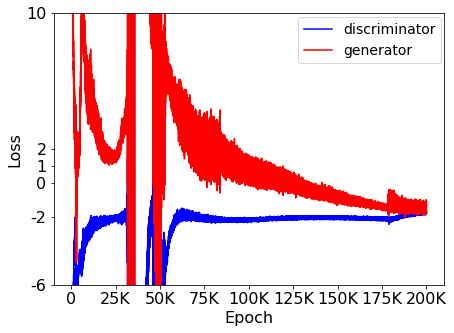

In [30]:
# plot training loss graph
plt.figure(figsize=(7,5))
plt.plot(disc_loss_results, c='blue', label='discriminator')
plt.plot(gen_loss_results, c='red', label='generator')
plt.legend(loc=1, fontsize=14, bbox_to_anchor=(1.01,1.01))

plt.ylim(-6,10.0)
plt.yticks([-6,-2,0,1,2,10], ['-6','-2','0','1','2', '10'], fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.xticks(np.arange(0, 210000, 25000), ['0', '25K','50K','75K', '100K', '125K', '150K', '175K', '200K'], fontsize=16)
plt.plot()

In [31]:
# Plot tSNE
from sklearn.manifold import TSNE
initx = np.concatenate((rld, gen_x[0]), axis=0)  #0
med1x = np.concatenate((rld, gen_x[50]), axis=0) #25K
med2x = np.concatenate((rld, gen_x[100]), axis=0) #50k
med3x = np.concatenate((rld, gen_x[150]), axis=0) #75K
med4x = np.concatenate((rld, gen_x[200]), axis=0) #100k
med5x = np.concatenate((rld, gen_x[250]), axis=0) #125k
med6x = np.concatenate((rld, gen_x[300]), axis=0) #150k
med7x = np.concatenate((rld, gen_x[350]), axis=0) #175k
endx = np.concatenate((rld, gen_x[400]), axis=0) # 200K
print (initx.shape, med1x.shape, med2x.shape, endx.shape)

tsne = TSNE()
tsne_init = tsne.fit_transform(initx)
tsne_med1 = tsne.fit_transform(med1x)
tsne_med2 = tsne.fit_transform(med2x)
tsne_med3 = tsne.fit_transform(med3x)
tsne_med4 = tsne.fit_transform(med4x)
tsne_med5 = tsne.fit_transform(med5x)
tsne_med6 = tsne.fit_transform(med6x)
tsne_med7 = tsne.fit_transform(med7x)
tsne_end = tsne.fit_transform(endx)
print (tsne_init.shape, tsne_med1.shape, tsne_med2.shape, tsne_end.shape)
print (len(rld), len(gen_x[0]))
n_rld = len(rld)
n_gen = len(gen_x)

(1830, 2254) (1830, 2254) (1830, 2254) (1830, 2254)
(1830, 2) (1830, 2) (1830, 2) (1830, 2)
1746 84


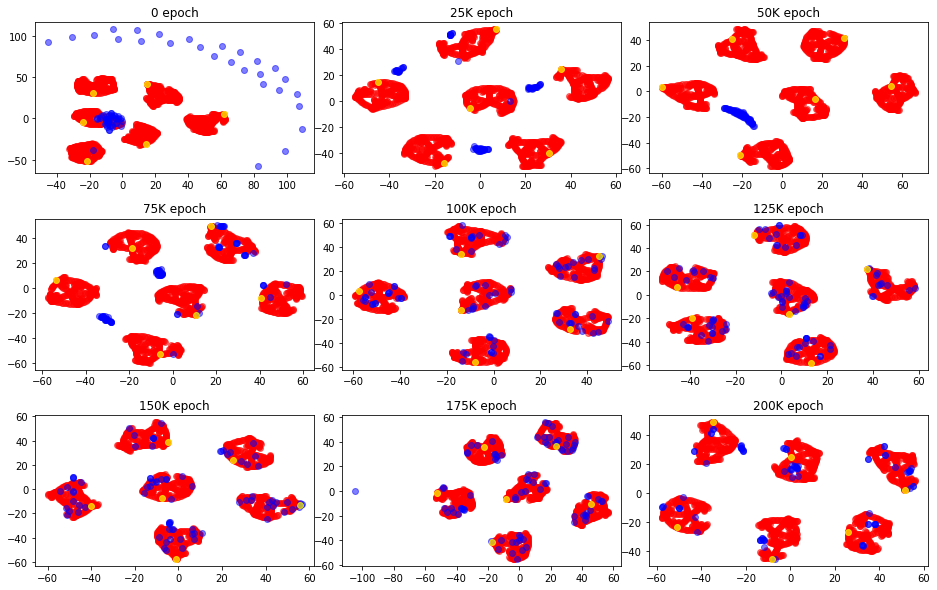

In [32]:
tsne_data = [tsne_init,tsne_med1,tsne_med2,tsne_med3,tsne_med4,tsne_med5,tsne_med6,tsne_med7,tsne_end]
title=["0 epoch", "25K epoch", "50K epoch","75K epoch","100K epoch","125K epoch","150K epoch","175K epoch",
       "200K epoch"]
plt.figure(figsize=(16,10))
for i in range(len(tsne_data)):
    input_data=tsne_data[i]
    h_num = math.ceil(len(tsne_data)/3)
    plt.subplot(h_num,3,i+1) 
    plt.subplots_adjust(wspace=0.1, hspace=0.3)
    plt.title(title[i])
    plt.scatter(input_data[:n_rld,0], input_data[:n_rld,1], alpha=0.5, c='red')
    plt.scatter(input_data[n_rld:n_rld+n_gen,0], input_data[n_rld:n_rld+n_gen,1], alpha=0.5, c='blue')
    plt.scatter(input_data[realidx,0], input_data[realidx,1], alpha=0.7, c='yellow')


In [33]:
# Restore the latest checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [34]:
n_noise = 10000
  
Fake10000z = get_noise(n_noise)
Fake10000 = generator(Fake10000z, training=False)
print(Fake10000z.shape, Fake10000.shape)

(10000, 100) (10000, 2254)


In [35]:
from scipy import stats
#generate augx for all samples
#caluclate Corr(fake_x, xte)
fake_real_corr = np.zeros((n_rld,))
Fakeallz, Fakeallx = np.zeros((n_rld,Fake10000z.shape[1])), np.zeros((n_rld,Fake10000.shape[1]))
print (fake_real_corr.shape)

genaugx = []
for i in range(n_rld):
    scorr_ary = np.zeros((n_noise,))
    tmp1 = rld[i]
    for j in range(n_noise):
        tmp2 = Fake10000[j]
        scorr_ary[j] = stats.pearsonr(tmp1, tmp2)[0]
    smaxidx = np.argsort(scorr_ary)[-10:]

    Fakeallz[i] = np.average(tf.gather(Fake10000z, smaxidx), axis=0)
    Fakeallx[i] = generator(np.reshape(Fakeallz[i], (1, 100)), training=False)
    fake_real_corr[i] = stats.pearsonr(tmp1, Fakeallx[i])[0]
    genaugx.append(Fakeallx[i])
genaugx = np.array(genaugx)
genaugx = genaugx.reshape((rld.shape))
print(genaugx.shape)
#save value
np.savez(sub_path+'/FakeAll_atEnd.npz', fake_real_corr=fake_real_corr,Fakeallx=Fakeallx,genaugx=genaugx) 

(1746,)
(1746, 2254)


In [36]:
Reload_FakeA_atE = np.load(sub_path+'/FakeAll_atEnd.npz')
Rel_fake_real_corr, Rel_Fakeallx, Rel_genaugx = Reload_FakeA_atE['fake_real_corr'],Reload_FakeA_atE['Fakeallx'],Reload_FakeA_atE['genaugx']
print(Rel_fake_real_corr.shape, np.shape(Rel_Fakeallx), np.shape(Rel_genaugx))

(1746,) (1746, 2254) (1746, 2254)


In [37]:
fake_real_corr, Fakeallx, genaugx = Rel_fake_real_corr, Rel_Fakeallx, Rel_genaugx

In [38]:
def plot_hist_re_rld(real, fake, bins):
    plt.figure(figsize=(20,7))
    plt.suptitle('Histogram of rescaled RLD', fontsize=36, y=1.03)
    plt.subplot(121)
    plt.hist(real.flatten(), bins=bins)
    plt.xlim(-0.1, 1.1)
    plt.ylim(0, 10000)
    plt.xticks(fontsize=34)
    #plt.yticks([0,2000,4000,6000,8000,10000], ['0', '2K', '4K', '6K', '8K', '10K'], fontsize=34)
    plt.xlabel('Rescaled RLD', fontsize=35)
    plt.ylabel('Counts', fontsize=35)
    plt.title('Real', fontsize=35)

    plt.subplot(122)
    plt.subplots_adjust(wspace=0.05)
    plt.hist(fake.flatten(), bins=bins, color='red')
    plt.xlim(-0.1, 1.1)
    plt.ylim(0, 10000)
    plt.xticks(fontsize=34)
    plt.yticks([0,2000,4000,6000,8000,10000],[])
    plt.xlabel('Rescaled RLD', fontsize=35)
    plt.title('Generated', fontsize=35)

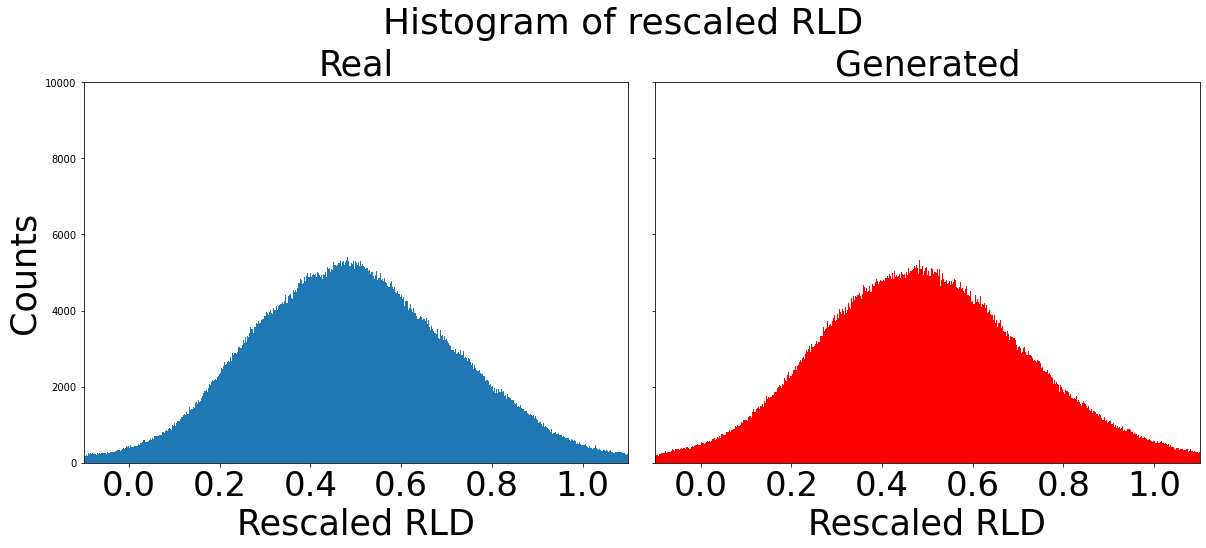

In [39]:
numBin = int((np.max(rld.flatten())-np.min(rld.flatten()))/0.005)
plot_hist_re_rld(rld, genaugx, 5000)

In [40]:
#Validate performance of network by comparing distribution of real and fake

real_corr = np.zeros((rld.shape[0], rld.shape[0]))
for i in range(rld.shape[0]):
    for j in range(rld.shape[0]):
        tmp1, tmp2 = rld[i], rld[j]
        real_corr[i,j] = stats.pearsonr(tmp1, tmp2)[0]

aug_corr = np.zeros((rld.shape[0], rld.shape[0]))
for i in range(len(aug_corr)):
    for j in range(len(aug_corr)):
        tmp1, tmp2 = rld[i], genaugx[j]
        aug_corr[i,j] = stats.pearsonr(tmp1,tmp2)[0]

In [41]:
def plot_hist_corr(real, fake, bins=100):
    plt.figure(figsize=(20,7))
    plt.suptitle('Histogram of correlation coefficient', fontsize=36, y=1.03)
    plt.subplot(121)
    plt.hist(real.flatten(), bins=bins)
    plt.xlim(-0.8,1.)
    plt.xticks([-0.75, -0.4, 0.0, 0.4, 0.75, 1.], fontsize=31)
    #plt.yticks([0, 4000, 8000, 12000, 16000], ['0', '4K', '8K', '12K', '16K'], fontsize=34)
    plt.xlabel('Correlation', fontsize=35)
    plt.ylabel('Counts', fontsize=35)
    plt.title('Real vs. Real', fontsize=35)

    plt.subplot(122)
    plt.subplots_adjust(wspace=0.12)
    plt.hist(fake.flatten(), bins=bins, color='red')
    plt.xlim(-0.8,1.)
    plt.xticks([-0.75, -0.4, 0.0, 0.4, 0.75, 1.], fontsize=31)
    plt.yticks([])
    plt.xlabel('Correlation', fontsize=35)
    plt.title('Real vs. Generated', fontsize=35)
    plt.plot()

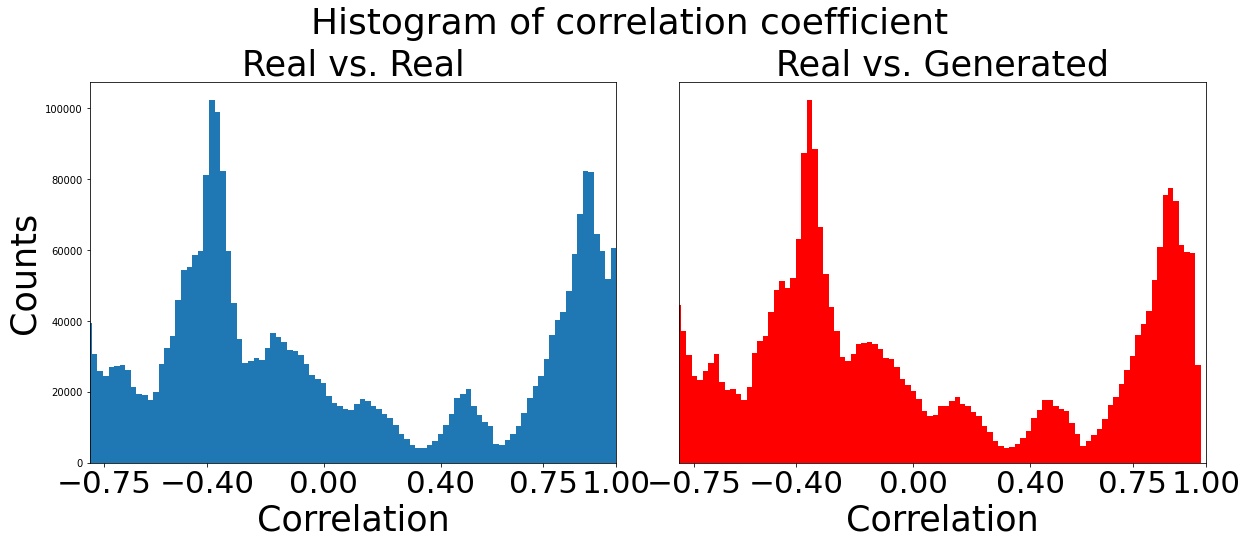

In [42]:
plot_hist_corr(real_corr, aug_corr)

In [43]:
# Label Indexing
Agg24 = np.array([0,96,173,231,270,290])
Agg72 = np.add(Agg24, 291)
Cont24, Cont72 = np.add(Agg24,2*291), np.add(Agg24,3*291)
Mono24, Mono72 = np.add(Agg24,4*291), np.add(Agg24,5*291)
Aug_Agg24 = np.arange(291)
Aug_Agg72 = np.add(Aug_Agg24,291)
Aug_Cont24, Aug_Cont72 = np.add(Aug_Agg24,2*291), np.add(Aug_Agg24,3*291)
Aug_Mono24, Aug_Mono72 = np.add(Aug_Agg24,4*291), np.add(Aug_Agg24,5*291)
print(Aug_Agg24)
print(augsample[Agg24])
print(augsample[Agg72])
print(augsample[Cont24])
print(augsample[Cont72])
print(augsample[Mono24])
print(augsample[Mono72])

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [44]:
print(rld.shape)
print(Agg24.shape,Aug_Agg24.shape)
OnlyAug_Agg24 = [e for e in Aug_Agg24 if e not in Agg24 ]
OnlyAug_Agg72 = [e for e in Aug_Agg72 if e not in Agg72 ]
OnlyAug_Cont24 = [e for e in Aug_Cont24 if e not in Cont24 ]
OnlyAug_Cont72 = [e for e in Aug_Cont72 if e not in Cont72 ]
OnlyAug_Mono24 = [e for e in Aug_Mono24 if e not in Mono24 ]
OnlyAug_Mono72 = [e for e in Aug_Mono72 if e not in Mono72 ]

x_Agg24 = rld[Agg24,:]
x_Agg72 = rld[Agg72,:]
x_Cont24 = rld[Cont24,:]
x_Cont72 = rld[Cont72,:]
x_Mono24 = rld[Mono24,:]
x_Mono72 = rld[Mono72,:]
x_OnlyAug_Agg24 = rld[OnlyAug_Agg24,:]
x_OnlyAug_Agg72 = rld[OnlyAug_Agg72,:]
x_OnlyAug_Cont24 = rld[OnlyAug_Cont24,:]
x_OnlyAug_Cont72 = rld[OnlyAug_Cont72,:]
x_OnlyAug_Mono24 = rld[OnlyAug_Mono24,:]
x_OnlyAug_Mono72 = rld[OnlyAug_Mono72,:]
x_real36=np.concatenate((x_Agg24,x_Agg72,x_Cont24,x_Cont72,x_Mono24,x_Mono72), axis=0)
x_OnlyAug810=np.concatenate((x_OnlyAug_Agg24,x_OnlyAug_Agg72,x_OnlyAug_Cont24,x_OnlyAug_Cont72,x_OnlyAug_Mono24,x_OnlyAug_Mono72),
                            axis=0)


(1746, 2254)
(6,) (291,)


In [45]:
ckpath = checkpoint_dir + "/cp-150000.ckpt-300"
print("restoring from " + ckpath)
checkpoint.restore(ckpath)

restoring from learning_logs/test/G450D270/training_checkpoints/cp-150000.ckpt-300


In [46]:
n_noise = 10000
  
Fake10000z = get_noise(n_noise)
Fake10000 = generator(Fake10000z, training=False)
print(Fake10000z.shape, Fake10000.shape)

(10000, 100) (10000, 2254)


In [47]:
n_real = 36
fake_real_corr = np.zeros((n_real,))
Fake36z, Fake36x = np.zeros((n_real,Fake10000z.shape[1])), np.zeros((n_real,Fake10000.shape[1]))
print (fake_real_corr.shape)

for i in range(n_real):
    scorr_ary = np.zeros((n_noise,))
    tmp1 = x_real36[i]
    for j in range(n_noise):
        tmp2 = Fake10000[j]
        scorr_ary[j] = stats.pearsonr(tmp1, tmp2)[0]
    smaxidx = np.argsort(scorr_ary)[-10:]
    
    Fake36z[i]=np.average(tf.gather(Fake10000z, smaxidx), axis=0)
    Fake36x[i]=generator(np.reshape(Fake36z[i],(1,100)), training=False)
    fake_real_corr[i] = stats.pearsonr(tmp1, Fake36x[i])[0]

(36,)


Max Corr Coeff = 0.998
Min Corr Coeff = 0.9386


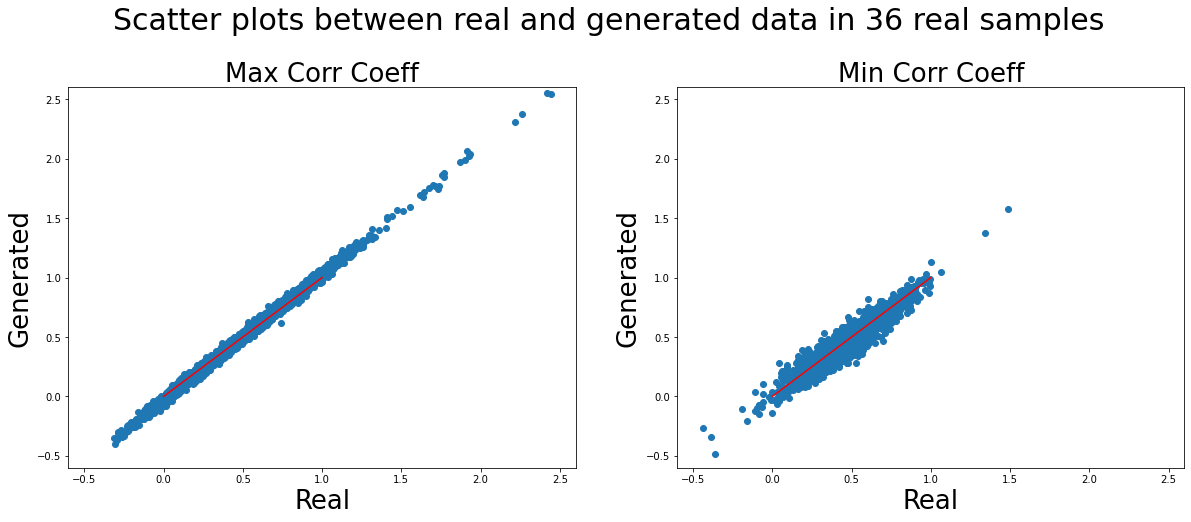

In [48]:
real_min = np.argmin(fake_real_corr)
real_max = np.argmax(fake_real_corr)

plt.figure(figsize=(20,7))
plt.suptitle('Scatter plots between real and generated data in 36 real samples',fontsize=30,y=1.04)

plt.subplot(121)
plt.scatter(x_real36[real_max],Fake36x[real_max])
plt.xlim(-0.6,2.6)
plt.ylim(-0.6,2.6)
plt.xlabel('Real',fontsize=26)
plt.ylabel('Generated',fontsize=26)
plt.title('Max Corr Coeff',fontsize=26)
plt.plot([0,1],color='red')

plt.subplot(122)
plt.scatter(x_real36[real_min],Fake36x[real_min])
plt.xlim(-0.6,2.6)
plt.ylim(-0.6,2.6)
plt.xlabel('Real',fontsize=26)
plt.ylabel('Generated',fontsize=26)
plt.title('Min Corr Coeff',fontsize=26)
plt.plot([0,1],color='red')
plt.plot()
print("Max Corr Coeff =",round(np.max(fake_real_corr,axis=0),4))
print("Min Corr Coeff =",round(np.min(fake_real_corr,axis=0),4))


In [49]:
fakex = np.concatenate((x_real36,x_OnlyAug810,Fake36x), axis=0)
fakex.shape
n_onlyaug = 810
tsne_real36 = tsne.fit_transform(x_real36)
tsne_onlyaug = tsne.fit_transform(x_OnlyAug810)
tsne_fakex = tsne.fit_transform(fakex)

Text(0.555, 0.42, 'D')

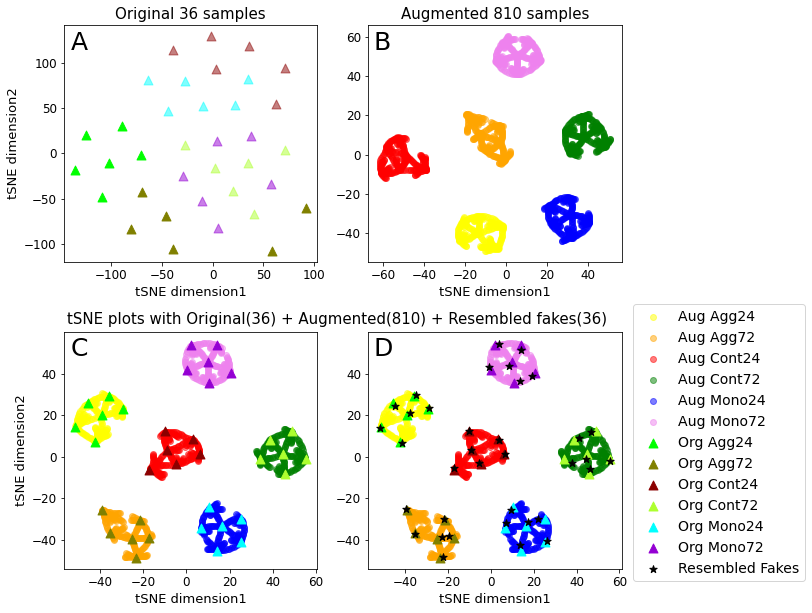

In [50]:
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.scatter(tsne_real36[0:6,0], tsne_real36[0:6,1], alpha=1.0, s=80, marker='^', c='lime')
plt.scatter(tsne_real36[6:12,0], tsne_real36[6:12,1], alpha=1.0, s=80, marker='^', c='olive')
plt.scatter(tsne_real36[12:18,0], tsne_real36[12:18,1], alpha=0.5, s=80, marker='^', c='darkred')
plt.scatter(tsne_real36[18:24,0], tsne_real36[18:24,1], alpha=0.5, s=80, marker='^', c='greenyellow')
plt.scatter(tsne_real36[24:30,0], tsne_real36[24:30,1], alpha=0.5, s=80, marker='^', c='cyan')
plt.scatter(tsne_real36[30:36,0], tsne_real36[30:36,1], alpha=0.5, s=80, marker='^', c='darkviolet')
plt.xlabel('tSNE dimension1', fontsize=13)
plt.ylabel('tSNE dimension2', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Original 36 samples',fontsize=15)

plt.subplot(2,2,2)
naug=285
plt.scatter(tsne_onlyaug[0:naug,0], tsne_onlyaug[0:naug,1], alpha=0.5, c='yellow')
plt.scatter(tsne_onlyaug[naug:2*naug,0], tsne_onlyaug[naug:2*naug,1], alpha=0.5, c='orange')
plt.scatter(tsne_onlyaug[2*naug:3*naug,0], tsne_onlyaug[2*naug:3*naug,1], alpha=0.5, c='red')
plt.scatter(tsne_onlyaug[3*naug:4*naug,0], tsne_onlyaug[3*naug:4*naug,1], alpha=0.5, c='green')
plt.scatter(tsne_onlyaug[4*naug:5*naug,0], tsne_onlyaug[4*naug:5*naug,1], alpha=0.5, c='blue')
plt.scatter(tsne_onlyaug[5*naug:6*naug,0], tsne_onlyaug[5*naug:6*naug,1], alpha=0.5, c='violet')
plt.xlabel('tSNE dimension1', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Augmented 810 samples',fontsize=15)

plt.subplot(2,2,3)
plt.scatter(tsne_fakex[n_real:n_real+naug,0], tsne_fakex[n_real:n_real+naug,1], alpha=0.5, c='yellow')
plt.scatter(tsne_fakex[n_real+naug:n_real+2*naug,0], tsne_fakex[n_real+naug:n_real+2*naug,1], alpha=0.5, c='orange')
plt.scatter(tsne_fakex[n_real+2*naug:n_real+3*naug,0], tsne_fakex[n_real+2*naug:n_real+3*naug,1], alpha=0.5, c='red')
plt.scatter(tsne_fakex[n_real+3*naug:n_real+4*naug,0], tsne_fakex[n_real+3*naug:n_real+4*naug,1], alpha=0.5, c='green')
plt.scatter(tsne_fakex[n_real+4*naug:n_real+5*naug,0], tsne_fakex[n_real+4*naug:n_real+5*naug,1], alpha=0.5, c='blue')
plt.scatter(tsne_fakex[n_real+5*naug:n_real+6*naug,0], tsne_fakex[n_real+5*naug:n_real+6*naug,1], alpha=0.5, c='violet')

plt.scatter(tsne_fakex[0:6,0], tsne_fakex[0:6,1], alpha=1.0, s=80, marker='^', c='lime')
plt.scatter(tsne_fakex[6:12,0], tsne_fakex[6:12,1], alpha=1.0, s=80, marker='^', c='olive')
plt.scatter(tsne_fakex[12:18,0], tsne_fakex[12:18,1], alpha=1.0, s=80, marker='^', c='darkred')
plt.scatter(tsne_fakex[18:24,0], tsne_fakex[18:24,1], alpha=1.0, s=80, marker='^', c='greenyellow')
plt.scatter(tsne_fakex[24:30,0], tsne_fakex[24:30,1], alpha=1.0, s=80, marker='^', c='cyan')
plt.scatter(tsne_fakex[30:36,0], tsne_fakex[30:36,1], alpha=1.0, s=80, marker='^', c='darkviolet')
plt.xlabel('tSNE dimension1', fontsize=13)
plt.ylabel('tSNE dimension2', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplot(2,2,4)

ps1 = plt.scatter(tsne_fakex[n_real:n_real+naug,0], tsne_fakex[n_real:n_real+naug,1], alpha=0.5, c='yellow')
ps2 = plt.scatter(tsne_fakex[n_real+naug:n_real+2*naug,0], tsne_fakex[n_real+naug:n_real+2*naug,1], alpha=0.5, c='orange')
ps3 = plt.scatter(tsne_fakex[n_real+2*naug:n_real+3*naug,0], tsne_fakex[n_real+2*naug:n_real+3*naug,1], alpha=0.5, c='red')
ps4 = plt.scatter(tsne_fakex[n_real+3*naug:n_real+4*naug,0], tsne_fakex[n_real+3*naug:n_real+4*naug,1], alpha=0.5, c='green')
ps5 = plt.scatter(tsne_fakex[n_real+4*naug:n_real+5*naug,0], tsne_fakex[n_real+4*naug:n_real+5*naug,1], alpha=0.5, c='blue')
ps6 = plt.scatter(tsne_fakex[n_real+5*naug:n_real+6*naug,0], tsne_fakex[n_real+5*naug:n_real+6*naug,1], alpha=0.5, c='violet')

ps7 = plt.scatter(tsne_fakex[0:6,0], tsne_fakex[0:6,1], alpha=1.0, s=80, marker='^', c='lime')
ps8 = plt.scatter(tsne_fakex[6:12,0], tsne_fakex[6:12,1], alpha=1.0, s=80, marker='^', c='olive')
ps9 = plt.scatter(tsne_fakex[12:18,0], tsne_fakex[12:18,1], alpha=1.0, s=80, marker='^', c='darkred')
ps10 = plt.scatter(tsne_fakex[18:24,0], tsne_fakex[18:24,1], alpha=1.0, s=80, marker='^', c='greenyellow')
ps11 = plt.scatter(tsne_fakex[24:30,0], tsne_fakex[24:30,1], alpha=1.0, s=80, marker='^', c='cyan')
ps12 = plt.scatter(tsne_fakex[30:36,0], tsne_fakex[30:36,1], alpha=1.0, s=80, marker='^', c='darkviolet')

ps13 = plt.scatter(tsne_fakex[n_real+6*naug:2*n_real+6*naug,0], tsne_fakex[n_real+6*naug:2*n_real+6*naug,1], alpha=1.0, s=60, marker='*', c='black')
plt.xlabel('tSNE dimension1', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.legend([ps1,ps2,ps3,ps4,ps5,ps6,ps7,ps8,ps9,ps10,ps11,ps12,ps13],
           ['Aug Agg24', 'Aug Agg72', 'Aug Cont24', 'Aug Cont72', 'Aug Mono24', 'Aug Mono72',
           'Org Agg24', 'Org Agg72', 'Org Cont24', 'Org Cont72', 'Org Mono24', 'Org Mono72',
           'Resembled Fakes'], 
           bbox_to_anchor=(1.75, 1.15), fontsize=14)

plt.subplots_adjust(hspace=0.3)

plt.figtext(0.13,0.465,'tSNE plots with Original(36) + Augmented(810) + Resembled fakes(36)',fontsize=15)
plt.figtext(0.135,0.845,'A',fontsize=25)
plt.figtext(0.555,0.845,'B',fontsize=25)
plt.figtext(0.135,0.42,'C',fontsize=25)
plt.figtext(0.555,0.42,'D',fontsize=25)

11.368545 14.870315


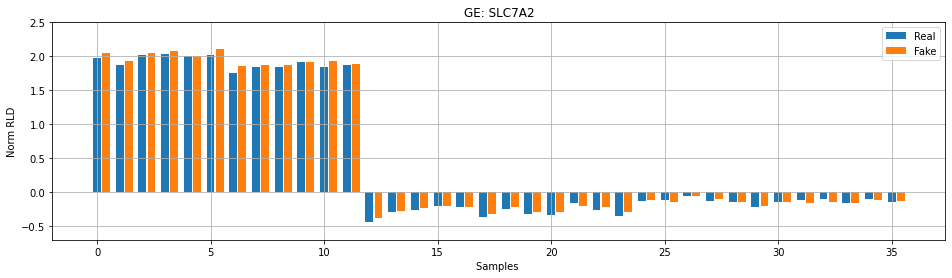

In [51]:
dam_idx = np.where(genelist=='SLC7A2')[0]
dam_min = np.min(rlds[te_idx,dam_idx])
dam_max = np.max(rlds[te_idx,dam_idx])
print(dam_min,dam_max)

plt.figure(figsize=(16,4))
xnp=np.arange(n_real)
plt.bar(xnp,x_real36[:,dam_idx].flatten(),width=0.35)
plt.bar(np.add(xnp,0.4),Fake36x[:,dam_idx].flatten(),width=0.35)
plt.legend(['Real','Fake'])
plt.title('GE: SLC7A2')
plt.ylabel('Norm RLD')
plt.xlabel('Samples ')
plt.ylim(-0.7,2.5)
plt.grid()

In [52]:
genelist,ex_gnames, ex_glists

(array(['TSPAN6', 'C1orf112', 'SEMA3F', ..., 'AL356534.1', 'H3C2', 'H3C3'],
       dtype=object),
 array(['ENSG00000000003', 'ENSG00000000460', 'ENSG00000001617', ...,
        'ENSG00000286215', 'ENSG00000286522', 'ENSG00000287080'],
       dtype=object),
 array(['TSPAN6', 'C1orf112', 'SEMA3F', ..., 'AL356534.1', 'H3C2', 'H3C3'],
       dtype=object))

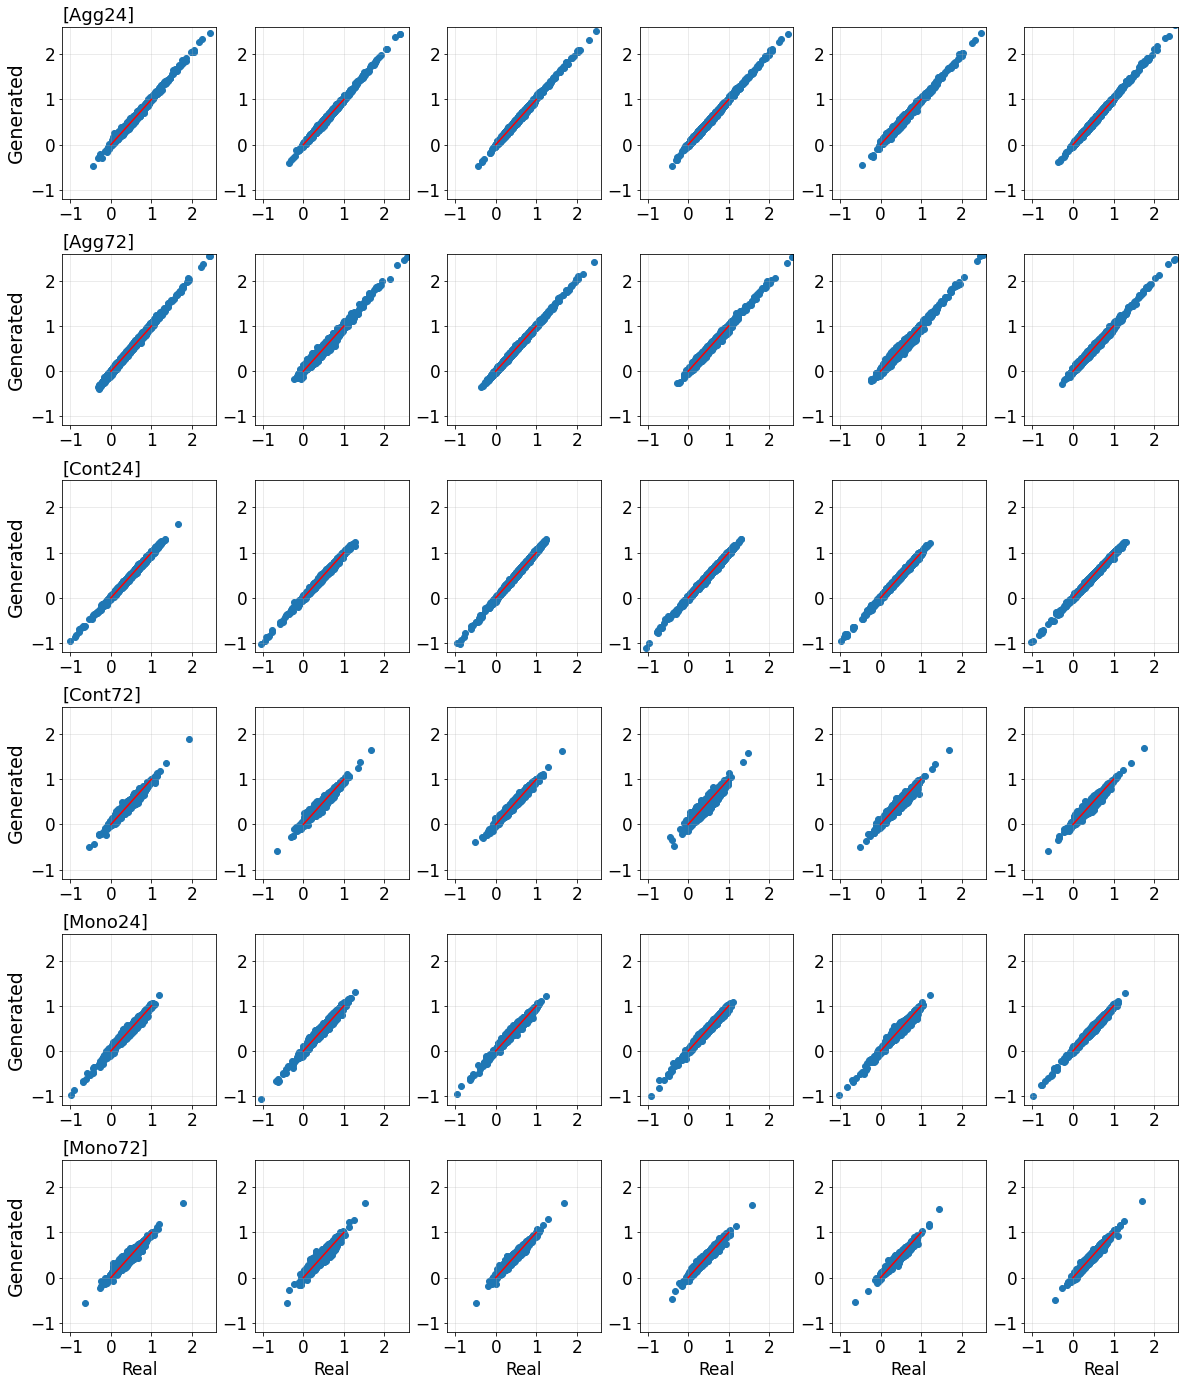

In [53]:
suptitle=['[Agg24]','[Agg72]','[Cont24]','[Cont72]','[Mono24]','[Mono72]']
plt.figure(figsize=(20,24))
for i in range(6): #type
    for j in range(6): #sample
        plt.subplot(6,6,(6*i+j+1))
        plt.subplots_adjust(wspace=0.25, hspace=0.32)
        plt.scatter(x_real36[i*6+j], Fake36x[i*6+j])
        plt.plot([0,1], color='red')
        plt.xlim(-1.2, 2.6)
        plt.ylim(-1.2, 2.6)
        plt.yticks(np.arange(-1,3,1), fontsize=17)
        plt.xticks(np.arange(-1,3,1), fontsize=17)
        plt.grid(alpha=0.3)
        if j==0:
            plt.ylabel('Generated', fontsize=19)
            plt.title(suptitle[i], loc='left', fontsize=18)
        if i==5:
            plt.xlabel('Real', fontsize=17)

In [54]:
epochs = np.arange(500, 200001, 500)
Pheno_index = [Agg24,Agg72,Cont24,Cont72,Mono24,Mono72]
Pheno_rld = [x_Agg24,x_Agg72,x_Cont24,x_Cont72,x_Mono24,x_Mono72]

In [55]:
AllE_Fake36z, AllE_Fake36x, AllE_Fake36_corr = [], [], []
for ep in range(len(epochs)):
    ckpath = checkpoint_dir + "/cp-" + str(epochs[ep]) + '.ckpt-' + str(ep+1)
    print("restoring from " + ckpath)
    checkpoint.restore(ckpath)
    
     
    noise_tmp = get_noise(n_noise)
    gen_tmp = generator(noise_tmp, training=False)
    print(noise_tmp.shape, gen_tmp.shape)
    
    OneE_Fake36z, OneE_Fake36x, OneE_Fake36_corr = [], [], []
    for pheno in range (len(Pheno_index)):
        tmpz_rld, tmpx_rld, tmp_corr = [], [], []
        for i in range (len(Pheno_index[pheno])):
            scorr_arr = np.zeros((n_noise,))
            pheno1_rld = Pheno_rld[pheno][i]
            for j in range (n_noise):
                scorr_arr[j] = stats.pearsonr(pheno1_rld, gen_tmp[j])[0]
            smaxidx = np.argsort(scorr_arr)[-10:]
            tmpz_avg = np.average(tf.gather(noise_tmp, smaxidx), axis=0)
            tmpx_avg = generator(np.reshape(tmpz_avg, (1, 100)), training=False)
            tmpz_rld.append(tmpz_avg)
            tmpx_rld.append(tmpx_avg)
            scorr_avg = stats.pearsonr(pheno1_rld, tmpx_avg[0])[0]
            tmp_corr.append(scorr_avg)
            
        OneE_Fake36z.append(tmpz_rld)
        OneE_Fake36x.append(tmpx_rld)
        OneE_Fake36_corr.append(tmp_corr)
    AllE_Fake36z.append(OneE_Fake36z)
    AllE_Fake36x.append(OneE_Fake36x)
    AllE_Fake36_corr.append(OneE_Fake36_corr)
    
AllE_Fake36z, AllE_Fake36x, AllE_Fake36_corr = np.array(AllE_Fake36z), np.array(AllE_Fake36x), np.array(AllE_Fake36_corr)
AllE_Fake36x = AllE_Fake36x.reshape(len(epochs),len(Pheno_index),len(Pheno_index[0]),len(Pheno_rld[pheno][0]))
                                  
print(AllE_Fake36z.shape, AllE_Fake36x.shape, AllE_Fake36_corr.shape)
np.savez(sub_path+'/AllE_Fake36.npz', AllE_Fake36z=AllE_Fake36z,AllE_Fake36x=AllE_Fake36x,AllE_Fake36_corr=AllE_Fake36_corr) 

restoring from learning_logs/test/G450D270/training_checkpoints/cp-500.ckpt-1
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-1000.ckpt-2
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-1500.ckpt-3
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-2000.ckpt-4
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-2500.ckpt-5
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-3000.ckpt-6
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-3500.ckpt-7
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-4000.ckpt-8
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-4500.ckpt-9
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/trai

(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-39000.ckpt-78
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-39500.ckpt-79
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-40000.ckpt-80
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-40500.ckpt-81
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-41000.ckpt-82
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-41500.ckpt-83
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-42000.ckpt-84
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-42500.ckpt-85
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-43000.ckpt-86
(10000, 100) (10000, 2254)
r

(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-77000.ckpt-154
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-77500.ckpt-155
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-78000.ckpt-156
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-78500.ckpt-157
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-79000.ckpt-158
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-79500.ckpt-159
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-80000.ckpt-160
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-80500.ckpt-161
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-81000.ckpt-162
(10000, 100) (10000

(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-114500.ckpt-229
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-115000.ckpt-230
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-115500.ckpt-231
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-116000.ckpt-232
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-116500.ckpt-233
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-117000.ckpt-234
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-117500.ckpt-235
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-118000.ckpt-236
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-118500.ckpt-237
(10000, 10

(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-152000.ckpt-304
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-152500.ckpt-305
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-153000.ckpt-306
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-153500.ckpt-307
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-154000.ckpt-308
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-154500.ckpt-309
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-155000.ckpt-310
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-155500.ckpt-311
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-156000.ckpt-312
(10000, 10

(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-189500.ckpt-379
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-190000.ckpt-380
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-190500.ckpt-381
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-191000.ckpt-382
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-191500.ckpt-383
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-192000.ckpt-384
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-192500.ckpt-385
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-193000.ckpt-386
(10000, 100) (10000, 2254)
restoring from learning_logs/test/G450D270/training_checkpoints/cp-193500.ckpt-387
(10000, 10

In [56]:
Reload = np.load(sub_path+'/AllE_Fake36.npz')
ReAllE_Fake36z, ReAllE_Fake36x, ReAllE_Fake36_corr = Reload['AllE_Fake36z'],Reload['AllE_Fake36x'],Reload['AllE_Fake36_corr']
print(ReAllE_Fake36z.shape, ReAllE_Fake36x.shape, ReAllE_Fake36_corr.shape)

(400, 6, 6, 100) (400, 6, 6, 2254) (400, 6, 6)


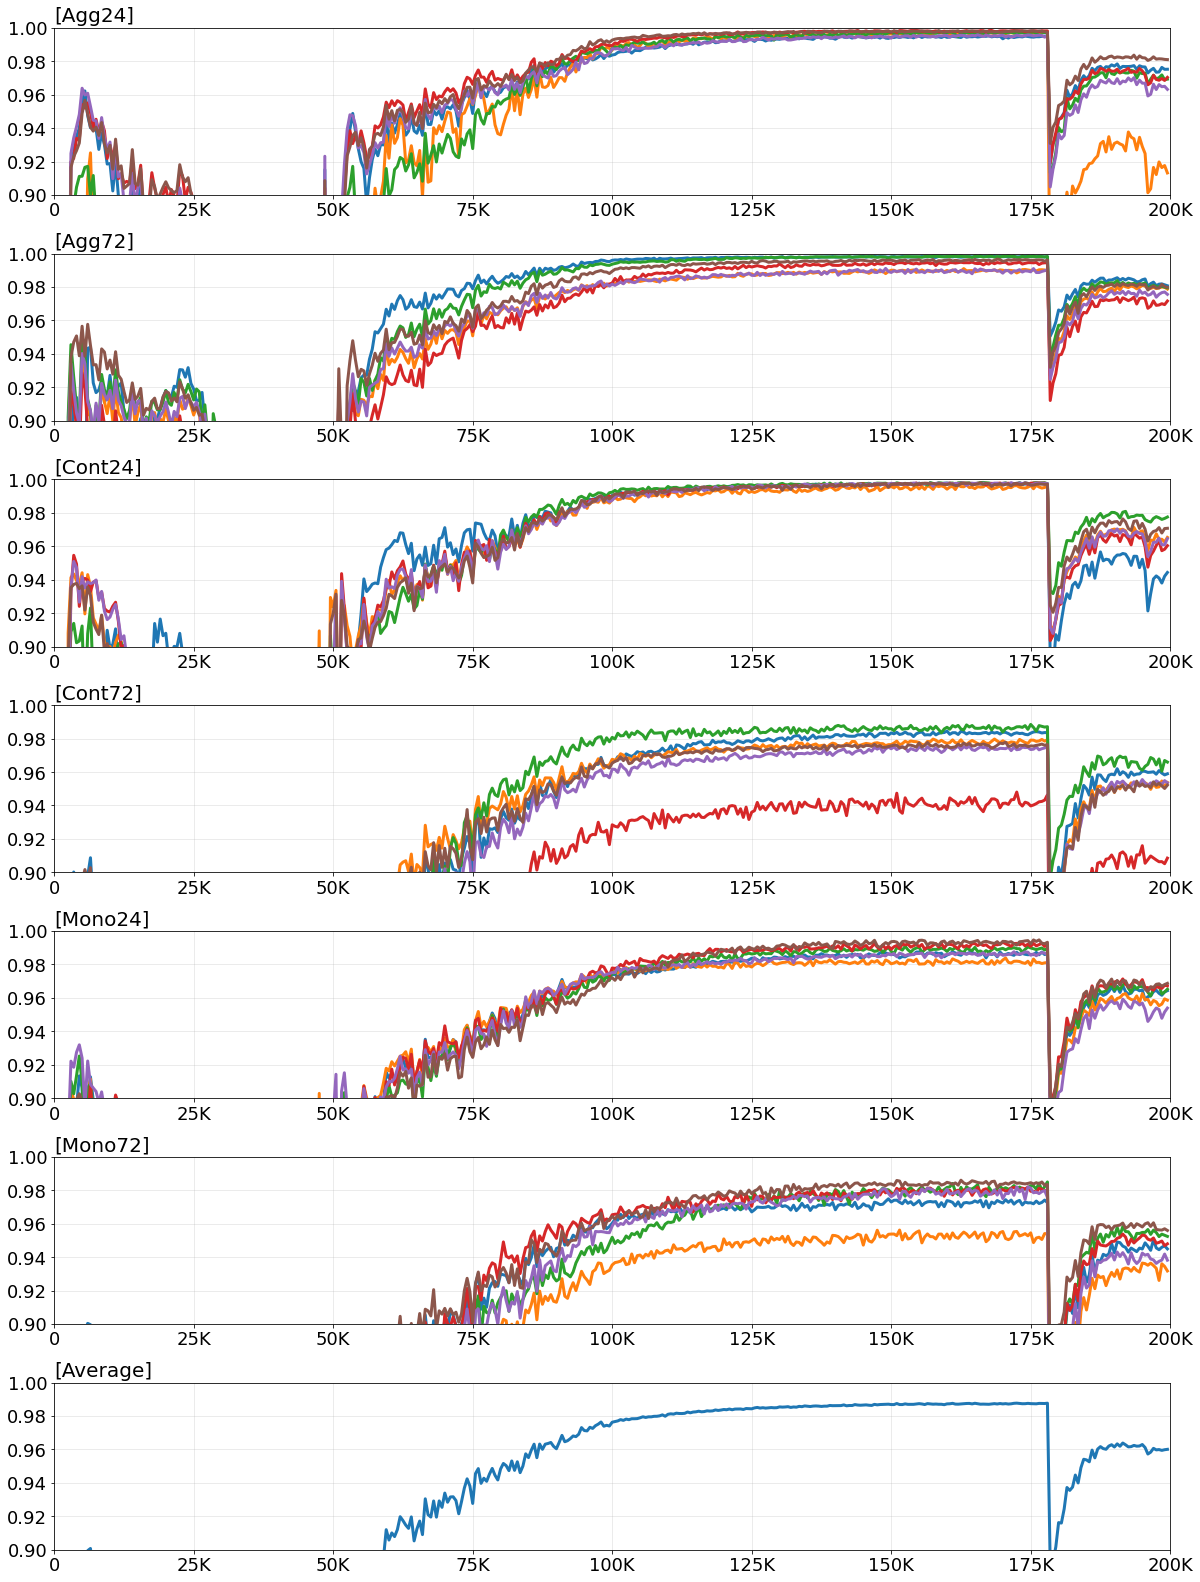

In [57]:
suptitle=['[Agg24]','[Agg72]','[Cont24]','[Cont72]','[Mono24]','[Mono72]']
plt.figure(figsize=(20,28))
for i in range(6):
    plt.subplot(7,1,i+1)
    plt.subplots_adjust(hspace=0.35)
    plt.title(suptitle[i], fontsize=20, loc='left')
    plt.ylim(0.9,1.0)
    plt.xlim(0,400)
    plt.yticks(fontsize=18)
    plt.xticks([0,50,100,150,200,250,300,350,400],['0','25K','50K','75K','100K','125K','150K','175K','200K'], fontsize=18)
    plt.grid(alpha=0.3)
    for j in range(6):
        plt.plot(ReAllE_Fake36_corr[:,i,j], linewidth=3.0)

plt.subplot(7,1,7)
plt.title('[Average]', fontsize=20, loc='left')
plt.ylim(0.9,1.0)
plt.xlim(0,400)
plt.yticks(fontsize=18)
plt.xticks([0,50,100,150,200,250,300,350,400],['0','25K','50K','75K','100K','125K','150K','175K','200K'], fontsize=18)
plt.grid(alpha=0.3)
plt.plot(np.average(np.average(ReAllE_Fake36_corr,axis=2),axis=1), linewidth=3.0)

## 4. Interpolation

### 4-1 Pheno type interpolation

In [62]:
cond_list = [Aug_Agg24,Aug_Agg72,Aug_Cont24,Aug_Cont72,Aug_Mono24,Aug_Mono72]
Latent_inlist = [[cond_list[5], cond_list[1]],[cond_list[3], cond_list[1]],
                 [cond_list[4], cond_list[0]],[cond_list[2], cond_list[0]],
                 [cond_list[3], cond_list[5]],[cond_list[2], cond_list[4]]]

M72toA72_inlist = [[cond_list[5], cond_list[1]]]
M24toA24_inlist = [[cond_list[4], cond_list[0]]]
ep_ary = np.arange(0,50500,500)+100000

union_condition_txt=['Agg24','Agg72','Cont24','Cont72','Mono24','Mono72']
union_condition = [union_condition_txt[5]+'to'+union_condition_txt[1],
                   union_condition_txt[3]+'to'+union_condition_txt[1],
                   union_condition_txt[4]+'to'+union_condition_txt[0],
                   union_condition_txt[2]+'to'+union_condition_txt[0],
                   union_condition_txt[3]+'to'+union_condition_txt[5],
                   union_condition_txt[2]+'to'+union_condition_txt[4]]
print(union_condition)

start_ep = 125000
ep_ary = np.arange(0,50500,500)+start_ep
start_ckpt = int(start_ep/500)
LatInt_epoch_txt= str(start_ep)[0:3]+'K'+str(start_ep+50000)[0:3]+'K'
print(LatInt_epoch_txt)

['Mono72toAgg72', 'Cont72toAgg72', 'Mono24toAgg24', 'Cont24toAgg24', 'Cont72toMono72', 'Cont24toMono24']
125K175K


In [63]:
from multiprocessing import Pool
import os
start = time.time()

#Setting according to user specifications
num_cores = 10
print(num_cores)

inlist = Latent_inlist

#Multiprocessing function
def work_func(j):

    scorr_ary = stats.pearsonr(rld[s_[s]], tmp_genx_as_array[j])[0]
    ecorr_ary = stats.pearsonr(rld[e_[s]], tmp_genx_as_array[j])[0]
    
    return [scorr_ary,ecorr_ary]

for i in range(len(inlist)):
    LatInt_z, LatInt_avgz, LatInt_genx  = [], [], []
    print("Start " + union_condition[i])
    
    for ep in range(len(ep_ary)):
        #if ep==1: break;
        ckpath = checkpoint_dir + "/cp-" + str(ep_ary[ep]) + '.ckpt-' + str(ep+start_ckpt)
        print("restoring from " + ckpath)
        checkpoint.restore(ckpath)

        tmpz = get_noise(n_noise)
        tmp_genx = generator(tmpz, training=False)    
        tmp_genx_as_array=np.array(tmp_genx,np.float32)#병렬처리를 위해 텐서플로어 변수와 병렬처리와의 충돌을 피하기 위한 로직 

        gens, gene = [], []

        s_, e_ = inlist[i][0], inlist[i][1]

        tmps, tmpe = [], []
        for s in range(len(s_)):
            #if s==1: break;
            scorr_ary, ecorr_ary = np.zeros((n_noise,)), np.zeros((n_noise,)) 
            #병렬 처리 
            if __name__ == "__main__":             

                start = int(time.time())
                
                
                pool = Pool(num_cores)
                work_result=np.array(pool.map(work_func,range(10000)))
                pool.terminate()

            smaxidx = np.argsort(work_result.T[0])[-10:]
            emaxidx = np.argsort(work_result.T[1])[-10:]
            tmps.append(np.average(tf.gather(tmpz, smaxidx),axis=0))
            tmpe.append(np.average(tf.gather(tmpz, emaxidx),axis=0))
        gens.append(tmps)
        gene.append(tmpe)
        #print(gens)

        gens, gene = np.array(gens), np.array(gene)
        delta_z = np.average(gene,axis=1)-np.average(gens,axis=1)
        inter_ = np.linspace(0., 1., num=101)

        LatInt_z.append([gens, gene])
        LatInt_avgz.append(delta_z)

        #generate fake by interpolating latent vector
        genx = []
        for ag in range(gens.shape[0]): #age
            tmpgenx = []
            for aug_sp in range(gens.shape[1]): #aug_samples
                ttmpgenx = []
                for z_ in inter_: #interpolate
                    tmpz = gens[ag][aug_sp] + (delta_z[ag]*z_)
                    tmpx = generator(tmpz.reshape((1,100)), training=False) 
                    ttmpgenx.append(tmpx)
                tmpgenx.append(ttmpgenx)
            genx.append(tmpgenx)
        genx = np.array(genx)
        genx = genx.reshape((len(delta_z), np.shape(gens)[1],len(inter_), p))

        LatInt_genx.append(genx)

    LatInt_z, LatInt_avgz = np.array(LatInt_z), np.array(LatInt_avgz)
    LatInt_genx = np.array(LatInt_genx) 
   
    #save value
    np.savez(sub_path+'/LatInt_225K275K_all.npz', LatInt_z=LatInt_z,LatInt_avgz=LatInt_avgz,LatInt_genx=LatInt_genx)
    file_name = '/LatInt_'+LatInt_epoch_txt+'_'+union_condition[i]+'.npz'
    np.savez(sub_path+file_name, LatInt_genx=LatInt_genx) 
    
elapsed_time = time.time() - start
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print ("Elapsed time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))



10
Start Mono72toAgg72
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125000.ckpt-250
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125500.ckpt-251
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126000.ckpt-252
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126500.ckpt-253
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127000.ckpt-254
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127500.ckpt-255
restoring from learning_logs/test/G450D270/training_checkpoints/cp-128000.ckpt-256
restoring from learning_logs/test/G450D270/training_checkpoints/cp-128500.ckpt-257
restoring from learning_logs/test/G450D270/training_checkpoints/cp-129000.ckpt-258
restoring from learning_logs/test/G450D270/training_checkpoints/cp-129500.ckpt-259
restoring from learning_logs/test/G450D270/training_checkpoints/cp-130000.ckpt-260
restoring from learning_logs/test/G450D270/training_checkpoints/

restoring from learning_logs/test/G450D270/training_checkpoints/cp-174500.ckpt-349
restoring from learning_logs/test/G450D270/training_checkpoints/cp-175000.ckpt-350
Start Cont72toAgg72
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125000.ckpt-250
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125500.ckpt-251
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126000.ckpt-252
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126500.ckpt-253
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127000.ckpt-254
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127500.ckpt-255
restoring from learning_logs/test/G450D270/training_checkpoints/cp-128000.ckpt-256
restoring from learning_logs/test/G450D270/training_checkpoints/cp-128500.ckpt-257
restoring from learning_logs/test/G450D270/training_checkpoints/cp-129000.ckpt-258
restoring from learning_logs/test/G450D270/training_checkpoints/cp-

restoring from learning_logs/test/G450D270/training_checkpoints/cp-173500.ckpt-347
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174000.ckpt-348
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174500.ckpt-349
restoring from learning_logs/test/G450D270/training_checkpoints/cp-175000.ckpt-350
Start Mono24toAgg24
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125000.ckpt-250
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125500.ckpt-251
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126000.ckpt-252
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126500.ckpt-253
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127000.ckpt-254
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127500.ckpt-255
restoring from learning_logs/test/G450D270/training_checkpoints/cp-128000.ckpt-256
restoring from learning_logs/test/G450D270/training_checkpoints/cp-

restoring from learning_logs/test/G450D270/training_checkpoints/cp-172500.ckpt-345
restoring from learning_logs/test/G450D270/training_checkpoints/cp-173000.ckpt-346
restoring from learning_logs/test/G450D270/training_checkpoints/cp-173500.ckpt-347
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174000.ckpt-348
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174500.ckpt-349
restoring from learning_logs/test/G450D270/training_checkpoints/cp-175000.ckpt-350
Start Cont24toAgg24
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125000.ckpt-250
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125500.ckpt-251
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126000.ckpt-252
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126500.ckpt-253
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127000.ckpt-254
restoring from learning_logs/test/G450D270/training_checkpoints/cp-

restoring from learning_logs/test/G450D270/training_checkpoints/cp-171500.ckpt-343
restoring from learning_logs/test/G450D270/training_checkpoints/cp-172000.ckpt-344
restoring from learning_logs/test/G450D270/training_checkpoints/cp-172500.ckpt-345
restoring from learning_logs/test/G450D270/training_checkpoints/cp-173000.ckpt-346
restoring from learning_logs/test/G450D270/training_checkpoints/cp-173500.ckpt-347
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174000.ckpt-348
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174500.ckpt-349
restoring from learning_logs/test/G450D270/training_checkpoints/cp-175000.ckpt-350
Start Cont72toMono72
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125000.ckpt-250
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125500.ckpt-251
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126000.ckpt-252
restoring from learning_logs/test/G450D270/training_checkpoints/cp

restoring from learning_logs/test/G450D270/training_checkpoints/cp-170500.ckpt-341
restoring from learning_logs/test/G450D270/training_checkpoints/cp-171000.ckpt-342
restoring from learning_logs/test/G450D270/training_checkpoints/cp-171500.ckpt-343
restoring from learning_logs/test/G450D270/training_checkpoints/cp-172000.ckpt-344
restoring from learning_logs/test/G450D270/training_checkpoints/cp-172500.ckpt-345
restoring from learning_logs/test/G450D270/training_checkpoints/cp-173000.ckpt-346
restoring from learning_logs/test/G450D270/training_checkpoints/cp-173500.ckpt-347
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174000.ckpt-348
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174500.ckpt-349
restoring from learning_logs/test/G450D270/training_checkpoints/cp-175000.ckpt-350
Start Cont24toMono24
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125000.ckpt-250
restoring from learning_logs/test/G450D270/training_checkpoints/cp

restoring from learning_logs/test/G450D270/training_checkpoints/cp-169500.ckpt-339
restoring from learning_logs/test/G450D270/training_checkpoints/cp-170000.ckpt-340
restoring from learning_logs/test/G450D270/training_checkpoints/cp-170500.ckpt-341
restoring from learning_logs/test/G450D270/training_checkpoints/cp-171000.ckpt-342
restoring from learning_logs/test/G450D270/training_checkpoints/cp-171500.ckpt-343
restoring from learning_logs/test/G450D270/training_checkpoints/cp-172000.ckpt-344
restoring from learning_logs/test/G450D270/training_checkpoints/cp-172500.ckpt-345
restoring from learning_logs/test/G450D270/training_checkpoints/cp-173000.ckpt-346
restoring from learning_logs/test/G450D270/training_checkpoints/cp-173500.ckpt-347
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174000.ckpt-348
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174500.ckpt-349
restoring from learning_logs/test/G450D270/training_checkpoints/cp-175000.ckpt-350
Elap

In [64]:
np.savez(sub_path+'/LatInt_225K275K_all.npz', LatInt_z=LatInt_z,LatInt_avgz=LatInt_avgz,LatInt_genx=LatInt_genx)
file_name = '/LatInt_'+LatInt_epoch_txt+'_'+union_condition[i]+'.npz'
np.savez(sub_path+file_name, LatInt_genx=LatInt_genx) 

### 4-2 aging interpolation

In [65]:
cond_list = [Aug_Agg24,Aug_Agg72,Aug_Cont24,Aug_Cont72,Aug_Mono24,Aug_Mono72]
Latent_inlist = [[cond_list[0], cond_list[1]],[cond_list[2], cond_list[3]],
                 [cond_list[4], cond_list[5]]]
union_condition_txt=['PFF24','PFF72','Cont24','Cont72','Mono24','Mono72']
union_condition_age = [union_condition_txt[0]+'to'+union_condition_txt[1],
                   union_condition_txt[2]+'to'+union_condition_txt[3],
                   union_condition_txt[4]+'to'+union_condition_txt[5]]


start_ep = 125000
ep_ary = np.arange(0,50500,500)+start_ep
start_ckpt = int(start_ep/500)
LatInt_epoch_txt= str(start_ep)[0:-3]+'K'+str(start_ep+50000)[0:-3]+'K'
print(LatInt_epoch_txt)

125K175K


In [67]:
from multiprocessing import Pool
import os
start = time.time()
num_cores = 10
print(num_cores)
inlist = Latent_inlist

#병렬 처리 ftn
def work_func(j):

    scorr_ary = stats.pearsonr(rld[s_[s]], tmp_genx_as_array[j])[0]
    ecorr_ary = stats.pearsonr(rld[e_[s]], tmp_genx_as_array[j])[0]
    
    return [scorr_ary,ecorr_ary]

for i in range(len(inlist)):
    LatInt_z, LatInt_avgz, LatInt_genx  = [], [], []
    print("Start " + union_condition_age[i])
    
    for ep in range(len(ep_ary)):
        #if ep==1: break;
        ckpath = checkpoint_dir + "/cp-" + str(ep_ary[ep]) + '.ckpt-' + str(ep+start_ckpt)
        print("restoring from " + ckpath)
        checkpoint.restore(ckpath)

        tmpz = get_noise(n_noise)
        tmp_genx = generator(tmpz, training=False)    
        tmp_genx_as_array=np.array(tmp_genx,np.float32)#병렬처리를 위해 텐서플로어 변수와 병렬처리와의 충돌을 피하기 위한 로직 

        gens, gene = [], []

        s_, e_ = inlist[i][0], inlist[i][1]

        tmps, tmpe = [], []
        for s in range(len(s_)):
            #if s==1: break;
            scorr_ary, ecorr_ary = np.zeros((n_noise,)), np.zeros((n_noise,)) 
            #병렬 처리 
            if __name__ == "__main__":             

                start = int(time.time())
                
                
                pool = Pool(num_cores)
                work_result=np.array(pool.map(work_func,range(10000)))
                pool.terminate()

            smaxidx = np.argsort(work_result.T[0])[-10:]
            emaxidx = np.argsort(work_result.T[1])[-10:]
            tmps.append(np.average(tf.gather(tmpz, smaxidx),axis=0))
            tmpe.append(np.average(tf.gather(tmpz, emaxidx),axis=0))
        gens.append(tmps)
        gene.append(tmpe)
        #print(gens)

        gens, gene = np.array(gens), np.array(gene)
        #print(gens.shape[1])
        #print(np.shape(gens)[1])
        delta_z = np.average(gene,axis=1)-np.average(gens,axis=1)
        inter_ = np.linspace(0., 1., num=101)

        LatInt_z.append([gens, gene])
        LatInt_avgz.append(delta_z)

        #generate fake by interpolating latent vector
        genx = []
        for ag in range(gens.shape[0]): #age
            tmpgenx = []
            for aug_sp in range(gens.shape[1]): #aug_samples
                ttmpgenx = []
                for z_ in inter_: #interpolate
                    tmpz = gens[ag][aug_sp] + (delta_z[ag]*z_)
                    tmpx = generator(tmpz.reshape((1,100)), training=False) 
                    ttmpgenx.append(tmpx)
                tmpgenx.append(ttmpgenx)
            genx.append(tmpgenx)
        genx = np.array(genx)
        genx = genx.reshape((len(delta_z), np.shape(gens)[1],len(inter_), p))

        LatInt_genx.append(genx)

    LatInt_z, LatInt_avgz = np.array(LatInt_z), np.array(LatInt_avgz)
    LatInt_genx = np.array(LatInt_genx) 
   
    #save value
    #np.savez(sub_path+'/LatInt_225K275K_all.npz', LatInt_z=LatInt_z,LatInt_avgz=LatInt_avgz,LatInt_genx=LatInt_genx)
    file_name = '/LatInt_'+LatInt_epoch_txt+'_'+union_condition_age[i]+'.npz'
    np.savez(sub_path+file_name, LatInt_genx=LatInt_genx) 
    #print(file_name)
    
elapsed_time = time.time() - start
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print ("Elapsed time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))



10
Start PFF24toPFF72
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125000.ckpt-250
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125500.ckpt-251
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126000.ckpt-252
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126500.ckpt-253
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127000.ckpt-254
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127500.ckpt-255
restoring from learning_logs/test/G450D270/training_checkpoints/cp-128000.ckpt-256
restoring from learning_logs/test/G450D270/training_checkpoints/cp-128500.ckpt-257
restoring from learning_logs/test/G450D270/training_checkpoints/cp-129000.ckpt-258
restoring from learning_logs/test/G450D270/training_checkpoints/cp-129500.ckpt-259
restoring from learning_logs/test/G450D270/training_checkpoints/cp-130000.ckpt-260
restoring from learning_logs/test/G450D270/training_checkpoints/c

restoring from learning_logs/test/G450D270/training_checkpoints/cp-174500.ckpt-349
restoring from learning_logs/test/G450D270/training_checkpoints/cp-175000.ckpt-350
Start Cont24toCont72
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125000.ckpt-250
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125500.ckpt-251
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126000.ckpt-252
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126500.ckpt-253
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127000.ckpt-254
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127500.ckpt-255
restoring from learning_logs/test/G450D270/training_checkpoints/cp-128000.ckpt-256
restoring from learning_logs/test/G450D270/training_checkpoints/cp-128500.ckpt-257
restoring from learning_logs/test/G450D270/training_checkpoints/cp-129000.ckpt-258
restoring from learning_logs/test/G450D270/training_checkpoints/cp

restoring from learning_logs/test/G450D270/training_checkpoints/cp-173500.ckpt-347
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174000.ckpt-348
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174500.ckpt-349
restoring from learning_logs/test/G450D270/training_checkpoints/cp-175000.ckpt-350
Start Mono24toMono72
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125000.ckpt-250
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125500.ckpt-251
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126000.ckpt-252
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126500.ckpt-253
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127000.ckpt-254
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127500.ckpt-255
restoring from learning_logs/test/G450D270/training_checkpoints/cp-128000.ckpt-256
restoring from learning_logs/test/G450D270/training_checkpoints/cp

restoring from learning_logs/test/G450D270/training_checkpoints/cp-172500.ckpt-345
restoring from learning_logs/test/G450D270/training_checkpoints/cp-173000.ckpt-346
restoring from learning_logs/test/G450D270/training_checkpoints/cp-173500.ckpt-347
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174000.ckpt-348
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174500.ckpt-349
restoring from learning_logs/test/G450D270/training_checkpoints/cp-175000.ckpt-350
Elapsed time: 00:12:59.07


### 4-3 interpolation result & make Transition curves

In [68]:
genx_A_aging, genx_S_aging=[], []
for i in range(len(union_condition_age)) :
    #if i==1 : break
    file_name = '/LatInt_'+LatInt_epoch_txt+'_'+union_condition_age[i]+'.npz'
    Reload_LatInt = np.load(sub_path+file_name)
    Rel_LatInt_genx = Reload_LatInt['LatInt_genx']
    genx_A_ind = np.average(np.average(Rel_LatInt_genx, axis=2), axis=0)
    genx_S_ind = np.std(np.average(Rel_LatInt_genx, axis=2), axis=0)
    genx_A_aging.append(genx_A_ind[0])
    genx_S_aging.append(genx_S_ind[0])
genx_A_aging=np.array(genx_A_aging)
genx_S_aging=np.array(genx_S_aging)
print(genx_A_aging.shape,genx_S_aging.shape)

(3, 101, 2254) (3, 101, 2254)


In [69]:
genx_A_pheno, genx_S_pheno=[], []
for i in range(len(union_condition)) :
    #if i==1 : break
    file_name = '/LatInt_'+LatInt_epoch_txt+'_'+union_condition[i]+'.npz'
    Reload_LatInt = np.load(sub_path+file_name)
    Rel_LatInt_genx = Reload_LatInt['LatInt_genx']
    genx_A_ind = np.average(np.average(Rel_LatInt_genx, axis=2), axis=0)
    genx_S_ind = np.std(np.average(Rel_LatInt_genx, axis=2), axis=0)
    genx_A_pheno.append(genx_A_ind[0])
    genx_S_pheno.append(genx_S_ind[0])
genx_A_pheno=np.array(genx_A_pheno)
genx_S_pheno=np.array(genx_S_pheno)
print(genx_A_pheno.shape,genx_S_pheno.shape)

(6, 101, 2254) (6, 101, 2254)


# Phenotype reverse interpolation

In [70]:
cond_list = [Aug_Agg24,Aug_Agg72,Aug_Cont24,Aug_Cont72,Aug_Mono24,Aug_Mono72]

Latent_inlist_pheno_re = [[cond_list[1], cond_list[5]],
                          [cond_list[1], cond_list[3]],
                          [cond_list[0], cond_list[4]],
                          [cond_list[0], cond_list[2]],
                          [cond_list[5], cond_list[3]],
                          [cond_list[4], cond_list[2]]]


M72toA72_inlist = [[cond_list[5], cond_list[1]]]
M24toA24_inlist = [[cond_list[4], cond_list[0]]]
ep_ary = np.arange(0,50500,500)+100000

union_condition_txt=['Agg24','Agg72','Cont24','Cont72','Mono24','Mono72']
union_condition = ['WT3MtoAD3M','WT3MtoAD6M','WT6MtoAD3M','WT6MtoAD6M']

union_condition_pheno_re = [union_condition_txt[1]+'to'+union_condition_txt[5],
                            union_condition_txt[1]+'to'+union_condition_txt[3],
                            union_condition_txt[0]+'to'+union_condition_txt[4],
                            union_condition_txt[0]+'to'+union_condition_txt[2],
                            union_condition_txt[5]+'to'+union_condition_txt[3],
                            union_condition_txt[4]+'to'+union_condition_txt[2]]
print(union_condition_pheno_re)

start_ep = 125000
ep_ary = np.arange(0,50500,500)+start_ep
start_ckpt = int(start_ep/500)
LatInt_epoch_txt= str(start_ep)[0:3]+'K'+str(start_ep+50000)[0:3]+'K'
print(LatInt_epoch_txt)

['Agg72toMono72', 'Agg72toCont72', 'Agg24toMono24', 'Agg24toCont24', 'Mono72toCont72', 'Mono24toCont24']
125K175K


In [71]:
from multiprocessing import Pool
import os
start = time.time()
num_cores = 6
inlist = Latent_inlist_pheno_re


#병렬 처리 ftn
def work_func(j):

    scorr_ary = stats.pearsonr(rld[s_[s]], tmp_genx_as_array[j])[0]
    ecorr_ary = stats.pearsonr(rld[e_[s]], tmp_genx_as_array[j])[0]
    
    return [scorr_ary,ecorr_ary]


for i in range(len(inlist)):
    LatInt_z, LatInt_avgz, LatInt_genx  = [], [], []
    print("Start " + union_condition_pheno_re[i])
    
    for ep in range(len(ep_ary)):
        #if ep==1: break;
        ckpath = checkpoint_dir + "/cp-" + str(ep_ary[ep]) + '.ckpt-' + str(ep+start_ckpt)
        print("restoring from " + ckpath)
        checkpoint.restore(ckpath)

        tmpz = get_noise(n_noise)
        tmp_genx = generator(tmpz, training=False)    
        tmp_genx_as_array=np.array(tmp_genx,np.float32)#병렬처리를 위해 텐서플로어 변수와 병렬처리와의 충돌을 피하기 위한 로직 

        gens, gene = [], []

        s_, e_ = inlist[i][0], inlist[i][1]

        tmps, tmpe = [], []
        for s in range(len(s_)):
            #if s==1: break;
            scorr_ary, ecorr_ary = np.zeros((n_noise,)), np.zeros((n_noise,)) 
            #병렬 처리 
            if __name__ == "__main__":             

           
                
                pool = Pool(num_cores)
                work_result=np.array(pool.map(work_func,range(10000)))
                pool.terminate()

            smaxidx = np.argsort(work_result.T[0])[-10:]
            emaxidx = np.argsort(work_result.T[1])[-10:]
            tmps.append(np.average(tf.gather(tmpz, smaxidx),axis=0))
            tmpe.append(np.average(tf.gather(tmpz, emaxidx),axis=0))
        gens.append(tmps)
        gene.append(tmpe)
        #print(gens)

        gens, gene = np.array(gens), np.array(gene)
        #print(gens.shape[1])
        #print(np.shape(gens)[1])
        delta_z = np.average(gene,axis=1)-np.average(gens,axis=1)
        inter_ = np.linspace(0., 1., num=101)

        LatInt_z.append([gens, gene])
        LatInt_avgz.append(delta_z)

        #generate fake by interpolating latent vector
        genx = []
        for ag in range(gens.shape[0]): #age
            tmpgenx = []
            for aug_sp in range(gens.shape[1]): #aug_samples
                ttmpgenx = []
                for z_ in inter_: #interpolate
                    tmpz = gens[ag][aug_sp] + (delta_z[ag]*z_)
                    tmpx = generator(tmpz.reshape((1,100)), training=False) 
                    ttmpgenx.append(tmpx)
                tmpgenx.append(ttmpgenx)
            genx.append(tmpgenx)
        genx = np.array(genx)
        genx = genx.reshape((len(delta_z), np.shape(gens)[1],len(inter_), p))

        LatInt_genx.append(genx)

    LatInt_z, LatInt_avgz = np.array(LatInt_z), np.array(LatInt_avgz)
    LatInt_genx = np.array(LatInt_genx) 
   
    #save value
    file_name = '/LatInt_'+LatInt_epoch_txt+'_'+union_condition_pheno_re[i]+'.npz'
    np.savez(sub_path+file_name, LatInt_genx=LatInt_genx) 
    #print(file_name)
    
elapsed_time = time.time() - start
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print ("Elapsed time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))


Start Agg72toMono72
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125000.ckpt-250
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125500.ckpt-251
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126000.ckpt-252
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126500.ckpt-253
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127000.ckpt-254
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127500.ckpt-255
restoring from learning_logs/test/G450D270/training_checkpoints/cp-128000.ckpt-256
restoring from learning_logs/test/G450D270/training_checkpoints/cp-128500.ckpt-257
restoring from learning_logs/test/G450D270/training_checkpoints/cp-129000.ckpt-258
restoring from learning_logs/test/G450D270/training_checkpoints/cp-129500.ckpt-259
restoring from learning_logs/test/G450D270/training_checkpoints/cp-130000.ckpt-260
restoring from learning_logs/test/G450D270/training_checkpoints/cp-

restoring from learning_logs/test/G450D270/training_checkpoints/cp-174500.ckpt-349
restoring from learning_logs/test/G450D270/training_checkpoints/cp-175000.ckpt-350
Start Agg72toCont72
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125000.ckpt-250
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125500.ckpt-251
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126000.ckpt-252
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126500.ckpt-253
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127000.ckpt-254
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127500.ckpt-255
restoring from learning_logs/test/G450D270/training_checkpoints/cp-128000.ckpt-256
restoring from learning_logs/test/G450D270/training_checkpoints/cp-128500.ckpt-257
restoring from learning_logs/test/G450D270/training_checkpoints/cp-129000.ckpt-258
restoring from learning_logs/test/G450D270/training_checkpoints/cp-

restoring from learning_logs/test/G450D270/training_checkpoints/cp-173500.ckpt-347
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174000.ckpt-348
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174500.ckpt-349
restoring from learning_logs/test/G450D270/training_checkpoints/cp-175000.ckpt-350
Start Agg24toMono24
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125000.ckpt-250
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125500.ckpt-251
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126000.ckpt-252
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126500.ckpt-253
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127000.ckpt-254
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127500.ckpt-255
restoring from learning_logs/test/G450D270/training_checkpoints/cp-128000.ckpt-256
restoring from learning_logs/test/G450D270/training_checkpoints/cp-

restoring from learning_logs/test/G450D270/training_checkpoints/cp-172500.ckpt-345
restoring from learning_logs/test/G450D270/training_checkpoints/cp-173000.ckpt-346
restoring from learning_logs/test/G450D270/training_checkpoints/cp-173500.ckpt-347
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174000.ckpt-348
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174500.ckpt-349
restoring from learning_logs/test/G450D270/training_checkpoints/cp-175000.ckpt-350
Start Agg24toCont24
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125000.ckpt-250
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125500.ckpt-251
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126000.ckpt-252
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126500.ckpt-253
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127000.ckpt-254
restoring from learning_logs/test/G450D270/training_checkpoints/cp-

restoring from learning_logs/test/G450D270/training_checkpoints/cp-171500.ckpt-343
restoring from learning_logs/test/G450D270/training_checkpoints/cp-172000.ckpt-344
restoring from learning_logs/test/G450D270/training_checkpoints/cp-172500.ckpt-345
restoring from learning_logs/test/G450D270/training_checkpoints/cp-173000.ckpt-346
restoring from learning_logs/test/G450D270/training_checkpoints/cp-173500.ckpt-347
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174000.ckpt-348
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174500.ckpt-349
restoring from learning_logs/test/G450D270/training_checkpoints/cp-175000.ckpt-350
Start Mono72toCont72
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125000.ckpt-250
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125500.ckpt-251
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126000.ckpt-252
restoring from learning_logs/test/G450D270/training_checkpoints/cp

restoring from learning_logs/test/G450D270/training_checkpoints/cp-170500.ckpt-341
restoring from learning_logs/test/G450D270/training_checkpoints/cp-171000.ckpt-342
restoring from learning_logs/test/G450D270/training_checkpoints/cp-171500.ckpt-343
restoring from learning_logs/test/G450D270/training_checkpoints/cp-172000.ckpt-344
restoring from learning_logs/test/G450D270/training_checkpoints/cp-172500.ckpt-345
restoring from learning_logs/test/G450D270/training_checkpoints/cp-173000.ckpt-346
restoring from learning_logs/test/G450D270/training_checkpoints/cp-173500.ckpt-347
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174000.ckpt-348
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174500.ckpt-349
restoring from learning_logs/test/G450D270/training_checkpoints/cp-175000.ckpt-350
Start Mono24toCont24
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125000.ckpt-250
restoring from learning_logs/test/G450D270/training_checkpoints/cp

restoring from learning_logs/test/G450D270/training_checkpoints/cp-169500.ckpt-339
restoring from learning_logs/test/G450D270/training_checkpoints/cp-170000.ckpt-340
restoring from learning_logs/test/G450D270/training_checkpoints/cp-170500.ckpt-341
restoring from learning_logs/test/G450D270/training_checkpoints/cp-171000.ckpt-342
restoring from learning_logs/test/G450D270/training_checkpoints/cp-171500.ckpt-343
restoring from learning_logs/test/G450D270/training_checkpoints/cp-172000.ckpt-344
restoring from learning_logs/test/G450D270/training_checkpoints/cp-172500.ckpt-345
restoring from learning_logs/test/G450D270/training_checkpoints/cp-173000.ckpt-346
restoring from learning_logs/test/G450D270/training_checkpoints/cp-173500.ckpt-347
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174000.ckpt-348
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174500.ckpt-349
restoring from learning_logs/test/G450D270/training_checkpoints/cp-175000.ckpt-350
Elap

## Aging reverse interpolation

In [72]:
## aging interpolationcond_list = [Aug_Agg24,Aug_Agg72,Aug_Cont24,Aug_Cont72,Aug_Mono24,Aug_Mono72]


Latent_inlist_age_re = [[cond_list[1], cond_list[0]],
                        [cond_list[3], cond_list[2]],
                        [cond_list[4], cond_list[4]]]





union_condition_txt=['PFF24','PFF72','Cont24','Cont72','Mono24','Mono72']

union_condition_age_re = [union_condition_txt[1]+'to'+union_condition_txt[0],
                          union_condition_txt[3]+'to'+union_condition_txt[2],
                          union_condition_txt[5]+'to'+union_condition_txt[4]]


start_ep = 125000
ep_ary = np.arange(0,50500,500)+start_ep
start_ckpt = int(start_ep/500)
LatInt_epoch_txt= str(start_ep)[0:-3]+'K'+str(start_ep+50000)[0:-3]+'K'
print(LatInt_epoch_txt)

125K175K


In [73]:
from multiprocessing import Pool
import os
start = time.time()
num_cores = 6
print(num_cores)
inlist = Latent_inlist_age_re

#병렬 처리 ftn
def work_func(j):

    scorr_ary = stats.pearsonr(rld[s_[s]], tmp_genx_as_array[j])[0]
    ecorr_ary = stats.pearsonr(rld[e_[s]], tmp_genx_as_array[j])[0]
    
    return [scorr_ary,ecorr_ary]

for i in range(len(inlist)):
    LatInt_z, LatInt_avgz, LatInt_genx  = [], [], []
    print("Start " + union_condition_age_re[i])
    
    for ep in range(len(ep_ary)):
        #if ep==1: break;
        ckpath = checkpoint_dir + "/cp-" + str(ep_ary[ep]) + '.ckpt-' + str(ep+start_ckpt)
        print("restoring from " + ckpath)
        checkpoint.restore(ckpath)

        tmpz = get_noise(n_noise)
        tmp_genx = generator(tmpz, training=False)    
        tmp_genx_as_array=np.array(tmp_genx,np.float32)#병렬처리를 위해 텐서플로어 변수와 병렬처리와의 충돌을 피하기 위한 로직 

        gens, gene = [], []

        s_, e_ = inlist[i][0], inlist[i][1]

        tmps, tmpe = [], []
        for s in range(len(s_)):
            #if s==1: break;
            scorr_ary, ecorr_ary = np.zeros((n_noise,)), np.zeros((n_noise,)) 
            #병렬 처리 
            if __name__ == "__main__":     
                
                pool = Pool(num_cores)
                work_result=np.array(pool.map(work_func,range(10000)))
                pool.terminate()

            smaxidx = np.argsort(work_result.T[0])[-10:]
            emaxidx = np.argsort(work_result.T[1])[-10:]
            tmps.append(np.average(tf.gather(tmpz, smaxidx),axis=0))
            tmpe.append(np.average(tf.gather(tmpz, emaxidx),axis=0))
        gens.append(tmps)
        gene.append(tmpe)
        #print(gens)

        gens, gene = np.array(gens), np.array(gene)
        #print(gens.shape[1])
        #print(np.shape(gens)[1])
        delta_z = np.average(gene,axis=1)-np.average(gens,axis=1)
        inter_ = np.linspace(0., 1., num=101)

        LatInt_z.append([gens, gene])
        LatInt_avgz.append(delta_z)

        #generate fake by interpolating latent vector
        genx = []
        for ag in range(gens.shape[0]): #age
            tmpgenx = []
            for aug_sp in range(gens.shape[1]): #aug_samples
                ttmpgenx = []
                for z_ in inter_: #interpolate
                    tmpz = gens[ag][aug_sp] + (delta_z[ag]*z_)
                    tmpx = generator(tmpz.reshape((1,100)), training=False) 
                    ttmpgenx.append(tmpx)
                tmpgenx.append(ttmpgenx)
            genx.append(tmpgenx)
        genx = np.array(genx)
        genx = genx.reshape((len(delta_z), np.shape(gens)[1],len(inter_), p))

        LatInt_genx.append(genx)

    LatInt_z, LatInt_avgz = np.array(LatInt_z), np.array(LatInt_avgz)
    LatInt_genx = np.array(LatInt_genx) 
   
    #save value
    #np.savez(sub_path+'/LatInt_225K275K_all.npz', LatInt_z=LatInt_z,LatInt_avgz=LatInt_avgz,LatInt_genx=LatInt_genx)
    file_name = '/LatInt_'+LatInt_epoch_txt+'_'+union_condition_age_re[i]+'.npz'
    np.savez(sub_path+file_name, LatInt_genx=LatInt_genx) 
    #print(file_name)
    
elapsed_time = time.time() - start
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print ("Elapsed time: {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))



6
Start PFF72toPFF24
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125000.ckpt-250
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125500.ckpt-251
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126000.ckpt-252
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126500.ckpt-253
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127000.ckpt-254
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127500.ckpt-255
restoring from learning_logs/test/G450D270/training_checkpoints/cp-128000.ckpt-256
restoring from learning_logs/test/G450D270/training_checkpoints/cp-128500.ckpt-257
restoring from learning_logs/test/G450D270/training_checkpoints/cp-129000.ckpt-258
restoring from learning_logs/test/G450D270/training_checkpoints/cp-129500.ckpt-259
restoring from learning_logs/test/G450D270/training_checkpoints/cp-130000.ckpt-260
restoring from learning_logs/test/G450D270/training_checkpoints/cp

restoring from learning_logs/test/G450D270/training_checkpoints/cp-174500.ckpt-349
restoring from learning_logs/test/G450D270/training_checkpoints/cp-175000.ckpt-350
Start Cont72toCont24
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125000.ckpt-250
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125500.ckpt-251
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126000.ckpt-252
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126500.ckpt-253
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127000.ckpt-254
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127500.ckpt-255
restoring from learning_logs/test/G450D270/training_checkpoints/cp-128000.ckpt-256
restoring from learning_logs/test/G450D270/training_checkpoints/cp-128500.ckpt-257
restoring from learning_logs/test/G450D270/training_checkpoints/cp-129000.ckpt-258
restoring from learning_logs/test/G450D270/training_checkpoints/cp

restoring from learning_logs/test/G450D270/training_checkpoints/cp-173500.ckpt-347
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174000.ckpt-348
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174500.ckpt-349
restoring from learning_logs/test/G450D270/training_checkpoints/cp-175000.ckpt-350
Start Mono72toMono24
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125000.ckpt-250
restoring from learning_logs/test/G450D270/training_checkpoints/cp-125500.ckpt-251
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126000.ckpt-252
restoring from learning_logs/test/G450D270/training_checkpoints/cp-126500.ckpt-253
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127000.ckpt-254
restoring from learning_logs/test/G450D270/training_checkpoints/cp-127500.ckpt-255
restoring from learning_logs/test/G450D270/training_checkpoints/cp-128000.ckpt-256
restoring from learning_logs/test/G450D270/training_checkpoints/cp

restoring from learning_logs/test/G450D270/training_checkpoints/cp-172500.ckpt-345
restoring from learning_logs/test/G450D270/training_checkpoints/cp-173000.ckpt-346
restoring from learning_logs/test/G450D270/training_checkpoints/cp-173500.ckpt-347
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174000.ckpt-348
restoring from learning_logs/test/G450D270/training_checkpoints/cp-174500.ckpt-349
restoring from learning_logs/test/G450D270/training_checkpoints/cp-175000.ckpt-350
Elapsed time: 27:37:05.34


In [74]:
genx_A_aging_reverse, genx_S_aging_reverse=[], []
for i in range(len(union_condition_age_re)) :
    #if i==1 : break
    file_name = '/LatInt_'+LatInt_epoch_txt+'_'+union_condition_age_re[i]+'.npz'
    Reload_LatInt = np.load(sub_path+file_name)
    Rel_LatInt_genx = Reload_LatInt['LatInt_genx']
    genx_A_ind = np.average(np.average(Rel_LatInt_genx, axis=2), axis=0)
    genx_S_ind = np.std(np.average(Rel_LatInt_genx, axis=2), axis=0)
    genx_A_aging_reverse.append(genx_A_ind[0])
    genx_S_aging_reverse.append(genx_S_ind[0])
genx_A_aging_reverse=np.array(genx_A_aging_reverse)
genx_S_aging_reverse=np.array(genx_S_aging_reverse)
print(genx_A_aging_reverse.shape,genx_S_aging_reverse.shape)

(3, 101, 2254) (3, 101, 2254)


In [75]:
genx_A_pheno_reverse, genx_S_pheno_reverse=[], []
for i in range(len(union_condition_pheno_re)) :
    #if i==1 : break
    file_name = '/LatInt_'+LatInt_epoch_txt+'_'+union_condition_pheno_re[i]+'.npz'
    Reload_LatInt = np.load(sub_path+file_name)
    Rel_LatInt_genx = Reload_LatInt['LatInt_genx']
    genx_A_ind = np.average(np.average(Rel_LatInt_genx, axis=2), axis=0)
    genx_S_ind = np.std(np.average(Rel_LatInt_genx, axis=2), axis=0)
    genx_A_pheno_reverse.append(genx_A_ind[0])
    genx_S_pheno_reverse.append(genx_S_ind[0])
genx_A_pheno_reverse=np.array(genx_A_pheno_reverse)
genx_S_pheno_reverse=np.array(genx_S_pheno_reverse)
print(genx_A_pheno_reverse.shape,genx_S_pheno_reverse.shape)

(6, 101, 2254) (6, 101, 2254)


## Transition curves 

In [76]:
genx_A_CMF_FB =np.array([(genx_A_pheno[5]+np.flip(genx_A_pheno_reverse[5], axis=0))/2,
                     (genx_A_pheno[2]+np.flip(genx_A_pheno_reverse[2], axis=0))/2,
                     (genx_A_pheno[4]+np.flip(genx_A_pheno_reverse[4], axis=0))/2,
                     (genx_A_pheno[0]+np.flip(genx_A_pheno_reverse[0], axis=0))/2])
genx_A_CMF_FB_re_1 = genx_A_CMF_FB.swapaxes(1,2)
genx_A_CMF_FB_re_2 = genx_A_CMF_FB_re_1.swapaxes(0,1)
genx_A_CMF_FB_complete = genx_A_CMF_FB_re_2.reshape(2254,-1)
print(genx_A_CMF_FB_complete.shape)      

(2254, 404)


In [77]:
genx_A_CMF_FB_complete

array([[ 0.4708611 ,  0.47160274,  0.47234446, ...,  0.31167817,
         0.311076  ,  0.3105278 ],
       [ 0.85016894,  0.8501178 ,  0.8500496 , ...,  0.29357532,
         0.29460979,  0.29568487],
       [ 0.6662286 ,  0.6657646 ,  0.66528493, ...,  0.3789984 ,
         0.37973458,  0.38055462],
       ...,
       [ 0.3943485 ,  0.3934257 ,  0.39251137, ...,  0.7351605 ,
         0.73642755,  0.73761463],
       [ 1.1385821 ,  1.1379678 ,  1.1373371 , ..., -0.11785109,
        -0.11689967, -0.11586256],
       [ 1.1143782 ,  1.1135261 ,  1.11266   , ..., -0.04951885,
        -0.04797687, -0.04634149]], dtype=float32)